In [1]:
import plot
import importlib
import numpy as np
import random
import os
import glob
import h5py
import math
import scipy
import random
import classify
import warnings
import preprocess
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from os import path
from scipy import stats
from scipy.io import loadmat
from matplotlib import gridspec
from numpy.linalg import norm
from scipy.spatial import distance
from sklearn import decomposition
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

np.random.seed(42)
random.seed(42)


In [2]:
# reload when updating code
importlib.reload(preprocess)
# mouse and date

mice = ['NN11'] 
dates_per_mouse = {'NN11': ['210626']}

for mouse in mice:
    dates = dates_per_mouse[mouse]  # Get the list of dates for the current mouse
    days = len(dates)  # Correct number of days for this mouse
    
    for day_idx, date in enumerate(dates):
        print(mouse, date)
        
        # Create folders to save files
        paths = preprocess.create_folders(mouse, date)
        print('folders created')
        
        # Import data for mouse and date as dict
        session_data = preprocess.load_data(paths)
        print('data loaded')
        
        # Process and plot behavior
        behavior = preprocess.process_behavior(session_data, paths)
        print('behavior done')
        
        # Save masks so can run in Matlab to process other planes
        # preprocess.cell_masks(paths, 0)
        print('masks saved')
        
        # Grab activity
        deconvolved = preprocess.process_activity(paths, 'spks', 3, 0)
        print('activity processed')
        
        # Normalize activity
        norm_deconvolved = preprocess.normalize_deconvolved(deconvolved, behavior, paths, 0)
        print('activity normalized')
        
        # Gaussian filter activity
        norm_moving_deconvolved_filtered = preprocess.difference_gaussian_filter(norm_deconvolved, 4, behavior, paths, 0)
        print('activity filtered')
        
        # Make trial-averaged traces and baseline subtract
        mean_cs_1_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_1')
        mean_cs_2_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_2')
        print('traces done')
        
        # Get significant cells
        [cs_1_poscells, cs_1_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_1')
        [cs_2_poscells, cs_2_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_2')
        [both_poscells, both_sigcells] = preprocess.combine_sig(cs_1_poscells, cs_1_negcells, cs_2_poscells, cs_2_negcells)
        print('sig cells done')
        
        # Get index of top cell differences
        idx = preprocess.get_index(behavior, mean_cs_1_responses_df, mean_cs_2_responses_df, cs_1_poscells, cs_2_poscells, both_poscells, both_sigcells, paths, 1)
        print('idx done')
        
        # Get prior for synchronous cue activity
        prior = classify.prior(norm_moving_deconvolved_filtered, idx['cs_1'], idx['cs_2'], behavior, [])
        print('prior done')
        
        # Logistic regression
        #y_pred, feature_importance_all = classify.log_regression_no_splits(behavior, norm_deconvolved, norm_moving_deconvolved_filtered, both_poscells, prior)
        y_pred_log, feature_importance_all = classify.log_regression_splits(behavior, norm_deconvolved, norm_moving_deconvolved_filtered, both_poscells, prior)

        print('logistic regression done')
        
        # Process classified output
        y_pred = classify.process_classified(y_pred_log, prior, paths, 1)
        print('classified done')
    


NN11 210626
folders created
data loaded
behavior done
masks saved
activity processed
activity normalized
activity filtered
traces done
sig cells done
idx done
prior done
logistic regression done
classified done


In [3]:
activity = norm_deconvolved.to_numpy()
activity = activity[idx['both'].index]

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

cos_sim = lambda a, b: np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
topn = 0.05

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

# Normalize the mean activities for each trial.
mean_activity_cs_1 = mean_activity_cs_1 / np.mean(mean_activity_cs_any, axis=0)
mean_activity_cs_2 = mean_activity_cs_2 / np.mean(mean_activity_cs_any, axis=0)

mean_activity_cs_1 = np.stack(mean_activity_cs_1, axis=0)
mean_activity_cs_2 = np.stack(mean_activity_cs_2, axis=0)

# Calculate the mean of the first and last three mean activities for cs_1 and cs_2.
n_centroids = 3
mean_activity_cs_1_mean = [np.mean(mean_activity_cs_1[0:n_centroids], axis=0), np.mean(mean_activity_cs_1[len(mean_activity_cs_1) - n_centroids:len(mean_activity_cs_1)], axis=0)]
mean_activity_cs_2_mean = [np.mean(mean_activity_cs_2[0:n_centroids], axis=0), np.mean(mean_activity_cs_2[len(mean_activity_cs_2) - n_centroids:len(mean_activity_cs_2)], axis=0)]

# Calculate the difference vectors between the early and late mean activities for cs_1 and cs_2.
mean_activity_cs_1_vec = mean_activity_cs_1_mean[1] - mean_activity_cs_1_mean[0]
mean_activity_cs_2_vec = mean_activity_cs_2_mean[1] - mean_activity_cs_2_mean[0]

late_trails_1 = mean_activity_cs_1_mean[1]
top_n_percent_indices_1 = np.argsort(late_trails_1)[-int(len(late_trails_1) * topn):]
mean_activity_cstopn_1 = mean_activity_cs_1[:, top_n_percent_indices_1]
mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

late_trails_2 = mean_activity_cs_2_mean[1]
top_n_percent_indices_2 = np.argsort(late_trails_2)[-int(len(late_trails_2) * topn):]
mean_activity_cstopn_2 = mean_activity_cs_2[:, top_n_percent_indices_2]
mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_cs_1 = np.zeros(len(mean_activity_cs_1))
sim_cs_2 = np.zeros(len(mean_activity_cs_2))

# Normalize the mean activities for each trial using the difference vectors.
for i in range(0, len(mean_activity_cs_1)):
    sim_cs_1[i] = cos_sim(mean_activity_cstopn_1[i], mean_activity_cstopn_1_late)
    # sim_cs_1[i] = cos_sim(mean_activity_cs_1[i], mean_activity_cs_1_mean[1])
    # sim_cs_1[i] = np.dot(mean_activity_cs_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_cs_2)):
    sim_cs_2[i] = cos_sim(mean_activity_cstopn_2[i], mean_activity_cstopn_2_late)
    # sim_cs_2[i] = cos_sim(mean_activity_cs_2[i], mean_activity_cs_2_mean[1])
    # sim_cs_2[i] = np.dot(mean_activity_cs_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)


# Initialize lists to store mean activities and trial indices for reactivation events.
mean_activity_r_1 = []
mean_activity_r_2 = []
mean_activity_r_any = []
trial_r_1 = []
trial_r_2 = []

# Copy reactivation predictions for cs_1 and cs_2.
reactivation_cs_1 = y_pred[:, 0].copy()
reactivation_cs_2 = y_pred[:, 1].copy()

# Set a threshold for reactivation probability.
p_threshold = .75

# Initialize variables for reactivation event detection.
cs_1_peak = 0
cs_2_peak = 0
i = 0
next_r = 0

# Loop through reactivation predictions to detect reactivation events.
while i < len(reactivation_cs_1) - 1:
    # Check if there is a reactivation event.
    if reactivation_cs_1[i] > 0 or reactivation_cs_2[i] > 0:
        if next_r == 0:
            r_start = i
            next_r = 1
        # Update peak reactivation values.
        if reactivation_cs_1[i] > cs_1_peak:
            cs_1_peak = reactivation_cs_1[i]
        if reactivation_cs_2[i] > cs_2_peak:
            cs_2_peak = reactivation_cs_2[i]
        #print(reactivation_cs_1[i + 1], reactivation_cs_2[i + 1])
        # Check if the reactivation event has ended.
        if reactivation_cs_1[i + 1] <= 0.001 and reactivation_cs_2[i + 1]<= 0.001:
            r_end = i + 1
            next_r = 0
            # Store mean activity and trial index for cs_1 reactivation events above the threshold.
            if cs_1_peak > p_threshold:
                for j in range(0, len(onsets_cs_1)):
                    if r_start < onsets_cs_1[j] and r_start > onsets_cs_1[j-1] and r_start < onsets_cs_1[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_1.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_1.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Store mean activity and trial index for cs_2 reactivation events above the threshold.
            if cs_2_peak > p_threshold:
                for j in range(0, len(onsets_cs_2)):
                    if r_start < onsets_cs_2[j] and r_start > onsets_cs_2[j-1] and r_start < onsets_cs_2[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_2.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_2.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Reset variables for the next reactivation event.
            i = r_end
            cs_1_peak = 0
            cs_2_peak = 0
    i += 1


# Normalize the reactivation mean activities.
mean_activity_r_1 = mean_activity_r_1 / np.mean(mean_activity_r_any, axis=0)
mean_activity_r_2 = mean_activity_r_2 / np.mean(mean_activity_r_any, axis=0)

mean_activity_r_1 = np.stack(mean_activity_r_1, axis=0)
mean_activity_r_2 = np.stack(mean_activity_r_2, axis=0)

# mean_activity_rtopn_1 = mean_activity_r_1[:, top_n_percent_indices_1]
# mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

# mean_activity_rtopn_2 = mean_activity_r_2[:, top_n_percent_indices_2]
# mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_r_1 = np.zeros(len(mean_activity_r_1))
sim_r_2 = np.zeros(len(mean_activity_r_2))

sim_r_1_random = np.zeros(len(mean_activity_r_1))

zero_indices = np.where(mean_activity_r_1 != 0)
    
# Normalize the reactivation mean activities using the difference vectors.
for i in range(0, len(mean_activity_r_1)):
    # nonzero_indices = np.where(mean_activity_r_1[i] != 0)
    top_n_percent_indices_r_1 = np.argsort(mean_activity_r_1[i])[-int(len(mean_activity_r_1[i]) * topn):]
    sim_r_1[i] = cos_sim(mean_activity_r_1[i][np.intersect1d(top_n_percent_indices_r_1, top_n_percent_indices_1)], mean_activity_cs_1_mean[1][np.intersect1d(top_n_percent_indices_r_1, top_n_percent_indices_1)])
    
    chosen_indices = np.random.randint(0, len(mean_activity_r_1[i]), 27)
    sim_r_1_random[i] = cos_sim(mean_activity_r_1[i][chosen_indices], mean_activity_cs_1_mean[1][chosen_indices])
    # sim_r_1[i] = cos_sim(mean_activity_rtopn_1[i], mean_activity_cstopn_1_late)
    # sim_r_1[i] = cos_sim(mean_activity_r_1[i], mean_activity_cs_1_mean[1])
    # sim_r_1[i] = np.dot(mean_activity_r_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_r_2)):
    # nonzero_indices = np.where(mean_activity_r_2[i] != 0)
    top_n_percent_indices_r_2 = np.argsort(mean_activity_r_2[i])[-int(len(mean_activity_r_2[i]) * topn):]
    sim_r_2[i] = cos_sim(mean_activity_r_2[i][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)], mean_activity_cs_2_mean[1][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)])
    # sim_r_2[i] = cos_sim(mean_activity_rtopn_2[i], mean_activity_cstopn_2_late)
    # sim_r_2[i] = cos_sim(mean_activity_r_2[i], mean_activity_cs_2_mean[1])
    # sim_r_2[i] = np.dot(mean_activity_r_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)


In [4]:
print(mean_activity_r_1.shape)
print(mean_activity_r_2.shape)

#print(trial_r_1)
#print(trial_r_2)

(139, 3124)
(111, 3124)


# Analysis predicting sign of change per neuron

In [14]:
def compute_sign_changes(mean_activity_cs, trial_r):
    """
    Compute sign changes based on trial-to-trial differences and map them to reactivations.
    
    Parameters:
    - mean_activity_cs: Trial-level activity (shape: trials x neurons)
    - trial_r: Reactivation-to-trial mapping (shape: reactivations,)
    
    Returns:
    - sign_changes: Array of sign changes mapped to reactivations (-1 or +1) for each neuron wrt the next SER trial.
    """
    
    # Compute trial-to-trial differences
    trial_diff = np.diff(mean_activity_cs, axis=0)  # Shape: (trials-1, neurons)

    # Compute signs of trial differences
    trial_sign_changes = np.where(trial_diff > 0, 1, -1)  # Shape: (trials-1, neurons)

    # Map trial-level changes to reactivations
    reactivation_sign_changes = trial_sign_changes[trial_r] 

    return reactivation_sign_changes

def clean_and_prepare_data(mean_activity_r, mean_activity_cs, trial_r):
    """
    Prepare predictors (X) and targets (y) for logistic regression
    
    Parameters:
    - mean_activity_r: Reactivation-level activity (shape: reactivations x neurons)
    - mean_activity_cs: Trial-level activity (shape: trials x neurons)
    - trial_r: Reactivation-to-trial mapping (shape: reactivations,)
    
    Returns:
    - X_all: Combined predictors (reactivation activity) for sensory evoked response (shape: total_reactivations, neurons).
    - y_all: Combined targets (sign changes) for all neurons (shape: total_reactivations, neurons).
    """
    X_list = []  # Predictors for all neurons
    y_list = []  # Targets for all neurons
    
    # Compute targets for all neurons
    for neuron in range(mean_activity_cs_1.shape[1]):
        y_neuron = compute_sign_changes(mean_activity_cs[:, neuron], trial_r)
        y_list.append(y_neuron)

    # Prepare predictors for the subset of neurons
    for neuron in range(mean_activity_r.shape[1]):
        # Adjust reactivation activity by subtracting the SER activity
        X_neuron = mean_activity_r[:, neuron] - mean_activity_cs[trial_r, neuron]
        X_list.append(X_neuron)
    
    # Stack all predictors and targets
    X_all = np.column_stack(X_list)  # Shape: (total_reactivations, subset_neurons)
    y_all = np.column_stack(y_list)  # Shape: (total_reactivations, total_neurons)
        
    return X_all, y_all

X_cs_1, y_cs_1_clean = clean_and_prepare_data(mean_activity_r_1, mean_activity_cs_1, trial_r_1)
X_cs_2, y_cs_2_clean = clean_and_prepare_data(mean_activity_r_2, mean_activity_cs_2, trial_r_2)

# Combine the datasets
X_all = np.concatenate([X_cs_1, X_cs_2])  # Shape: (total_reactivations, neurons)
y_all = np.concatenate([y_cs_1_clean, y_cs_2_clean]) 

print(X_all.shape, y_all.shape)

# Sanity check the processed targets
unique_cs_1, counts_cs_1 = np.unique(y_cs_1_clean, return_counts=True)
unique_cs_2, counts_cs_2 = np.unique(y_cs_2_clean, return_counts=True)

print("Processed Targets for CS_1:")
print(dict(zip(unique_cs_1, counts_cs_1)))
print("\nProcessed Targets for CS_2:")
print(dict(zip(unique_cs_2, counts_cs_2)))
print(trial_r_1)
#print(mean_activity_r_1.shape)
print(trial_r_2)

trial_types = behavior["cue_codes"]
print(trial_types)

(250, 3124) (250, 3124)
Processed Targets for CS_1:
{-1: 216563, 1: 217673}

Processed Targets for CS_2:
{-1: 173997, 1: 172767}
[1, 1, 1, 2, 2, 2, 3, 3, 4, 5, 5, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21, 21, 21, 23, 24, 25, 25, 26, 26, 27, 28, 29, 29, 29, 30, 30, 30, 30, 31, 33, 34, 34, 34, 35, 36, 37, 38, 39, 39, 40, 40, 41, 41, 42, 42, 43, 44, 44, 45, 45, 46, 47, 48, 50, 51, 52, 52, 52, 53, 53, 54, 54, 54, 55, 55, 55, 55, 56, 57, 57, 57, 57, 58, 58, 58, 58, 58, 59, 59, 59, 60, 60, 61, 61, 61, 62, 62, 62, 62, 63, 63, 64, 64, 64, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66]
[0, 1, 1, 1, 2, 3, 3, 3, 4, 5, 5, 6, 6, 7, 7, 8, 8, 8, 9, 9, 10, 11, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 17, 18, 18, 18, 19, 19, 21, 22, 22, 23, 24, 25, 26, 26, 26, 26, 27, 27, 28, 28, 28, 29, 29, 29, 30, 30, 31, 31, 31, 32, 32, 33, 33, 34, 35, 38, 40, 40, 41, 41, 41, 42, 43, 43, 44, 45, 45, 46, 47, 48, 48, 49, 49, 49, 4

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputClassifier


def evaluate_fold(model, X_train, X_test, y_train, y_test, test_idx):
    """Trains the model and evaluates metrics for a single CV fold.
       Also returns predictions and test indices so we can track
       which events (rows) were in this fold.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute metrics for each output (neuron)
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1s = []

    for neuron_idx in range(y_test.shape[1]):
        y_test_n = y_test[:, neuron_idx]
        y_pred_n = y_pred[:, neuron_idx]

        fold_accuracies.append(accuracy_score(y_test_n, y_pred_n))
        fold_precisions.append(precision_score(y_test_n, y_pred_n, zero_division=0))
        fold_recalls.append(recall_score(y_test_n, y_pred_n, zero_division=0))
        fold_f1s.append(f1_score(y_test_n, y_pred_n, zero_division=0))

    return (fold_accuracies, fold_precisions, fold_recalls, fold_f1s,
            y_test, y_pred, test_idx)


def LR_model(X_all, y_all):
    print(f"X_all shape: {X_all.shape}, y_all shape: {y_all.shape}")

    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Model initialization
    base_model = LogisticRegression(
        max_iter=1000, 
        random_state=42,
        solver="lbfgs",
        penalty="l2", 
        class_weight="balanced"
    )
    model_cv = MultiOutputClassifier(base_model)

    # Parallel cross-validation
    all_results = Parallel(n_jobs=-1)(
        delayed(evaluate_fold)(
            model_cv,
            X_all[train_idx], X_all[test_idx],
            y_all[train_idx], y_all[test_idx],
            test_idx
        )
        for train_idx, test_idx in kf.split(X_all)
    )

    # Unpack results
    (all_accuracies, all_precisions, all_recalls, all_f1s,
     all_y_test, all_y_pred, all_test_idx) = zip(*all_results)

    # 1. Flatten or concatenate the metrics across folds
    all_accuracies = np.concatenate(all_accuracies)
    all_precisions = np.concatenate(all_precisions)
    all_recalls = np.concatenate(all_recalls)
    all_f1s = np.concatenate(all_f1s)

    # 2. Reconstruct out-of-fold predictions for each row
    #    so we know exactly how each reactivation event was classified.
    #    First, allocate an array the same shape as y_all for predictions:
    oof_preds = np.zeros_like(y_all)
    oof_true  = np.zeros_like(y_all)

    for fold_idx, test_indices in enumerate(all_test_idx):
        y_pred_fold = all_y_pred[fold_idx]  # shape: (len(test_indices), n_outputs)
        y_test_fold = all_y_test[fold_idx]  # shape: (len(test_indices), n_outputs)

        oof_preds[test_indices] = y_pred_fold
        oof_true[test_indices]  = y_test_fold

    # --- Summaries ---
    print("\n=== Cross-Validation Summary ===")
    print(f"Accuracy:  {np.mean(all_accuracies):.3f} ± {np.std(all_accuracies):.3f}")
    print(f"Precision: {np.mean(all_precisions):.3f}")
    print(f"Recall:    {np.mean(all_recalls):.3f}")
    print(f"F1-score:  {np.mean(all_f1s):.3f}")

    metrics_dict = {
        "Accuracy": all_accuracies,
        "Precision": all_precisions,
        "Recall": all_recalls,
        "F1": all_f1s
    }

    # Plot distributions
    plt.figure(figsize=(12, 8))
    for i, (metric_name, values) in enumerate(metrics_dict.items()):
        plt.subplot(2, 2, i+1)
        plt.hist(values, bins=100, alpha=0.7, color='b')
        plt.title(f"Distribution of {metric_name} (all folds, all neurons)")
        plt.xlabel(metric_name)
        plt.ylabel("Count")

    plt.tight_layout()
    plt.show()

    # --- Return or store the per-event predictions for further analysis ---
    return oof_preds, oof_true


In [9]:
def mean_reactivations_by_trial(mean_activity_r, trial_r, n_trials):
   
    n_reactivations, n_neurons = mean_activity_r.shape
    
    # Accumulate sums of reactivation activity per trial
    trial_sums = np.zeros((n_trials, n_neurons), dtype=float)
    reactivation_counts = np.zeros(n_trials, dtype=int)
    
    for i in range(n_reactivations):
        trial_index = trial_r[i]
        trial_sums[trial_index] += mean_activity_r[i]
        reactivation_counts[trial_index] += 1

    # Compute mean, handling zero-reactivation trials
    trial_means = np.zeros_like(trial_sums)
    for t in range(n_trials):
        if reactivation_counts[t] > 0:
            trial_means[t] = trial_sums[t] / reactivation_counts[t]
        else:
            trial_means[t] = 0
    
    return trial_means

mean_mean_activity_r1 = mean_reactivations_by_trial(mean_activity_r_1, trial_r_1, n_trials=mean_activity_cs_1.shape[0])
print(mean_mean_activity_r1.shape)
mean_mean_activity_r2 = mean_reactivations_by_trial(mean_activity_r_2, trial_r_2, n_trials=mean_activity_cs_2.shape[0])
print(mean_mean_activity_r2.shape)


(68, 3124)
(60, 3124)


(68, 3124)
(60, 3124)
(126, 3124)
[[ 1 -1 -1 ... -1  1 -1]
 [ 1  1 -1 ... -1  1 -1]
 [ 1 -1  1 ...  1 -1 -1]
 ...
 [-1  1  1 ... -1 -1  1]
 [-1 -1 -1 ...  1  1 -1]
 [ 1  1  1 ... -1 -1  1]]
X_all shape: (126, 3124), y_all shape: (126, 3124)



=== Cross-Validation Summary ===
Accuracy:  0.520 ± 0.102
Precision: 0.518
Recall:    0.526
F1-score:  0.507


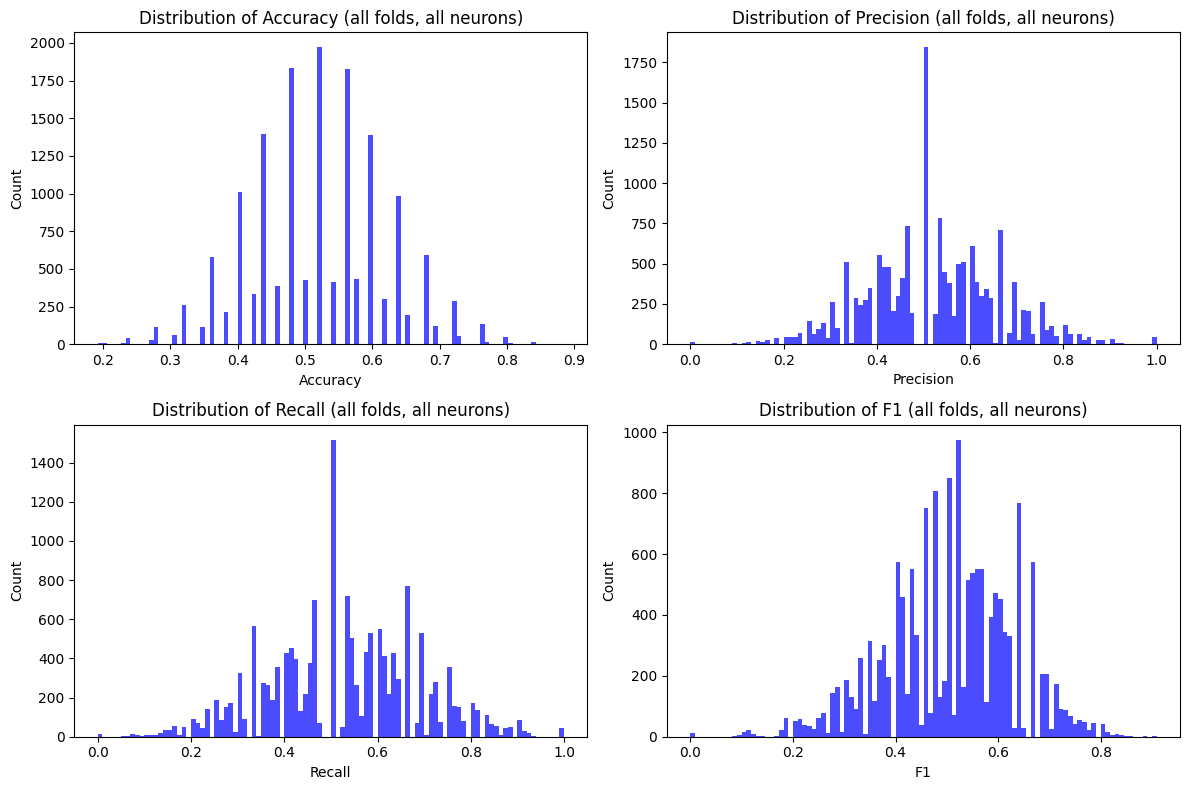

In [10]:
X_1 = mean_mean_activity_r1 - mean_activity_cs_1
print(X_1.shape)
X_2 = mean_mean_activity_r2 - mean_activity_cs_2
print(X_2.shape)
x_all = np.concatenate([X_1[:-1, ], X_2[:-1, ]])
print(x_all.shape)

y_1 = np.diff(mean_activity_cs_1, axis=0)
y_2 = np.diff(mean_activity_cs_2, axis=0)

y_all = np.concatenate([y_1, y_2])

sign_changes = np.where(y_all > 0, 1, -1)
print(sign_changes)

#Ri - SERt-1 (compressed in SER space)
LR_model(x_all, sign_changes)


[[ 1 -1 -1 ... -1  1 -1]
 [ 1  1 -1 ... -1  1 -1]
 [ 1 -1  1 ...  1 -1 -1]
 ...
 [-1  1  1 ... -1 -1  1]
 [-1 -1 -1 ...  1  1 -1]
 [ 1  1  1 ... -1 -1  1]]
X_all shape: (126, 3124), y_all shape: (126, 3124)

=== Cross-Validation Summary ===
Accuracy:  0.511 ± 0.104
Precision: 0.507
Recall:    0.518
F1-score:  0.497


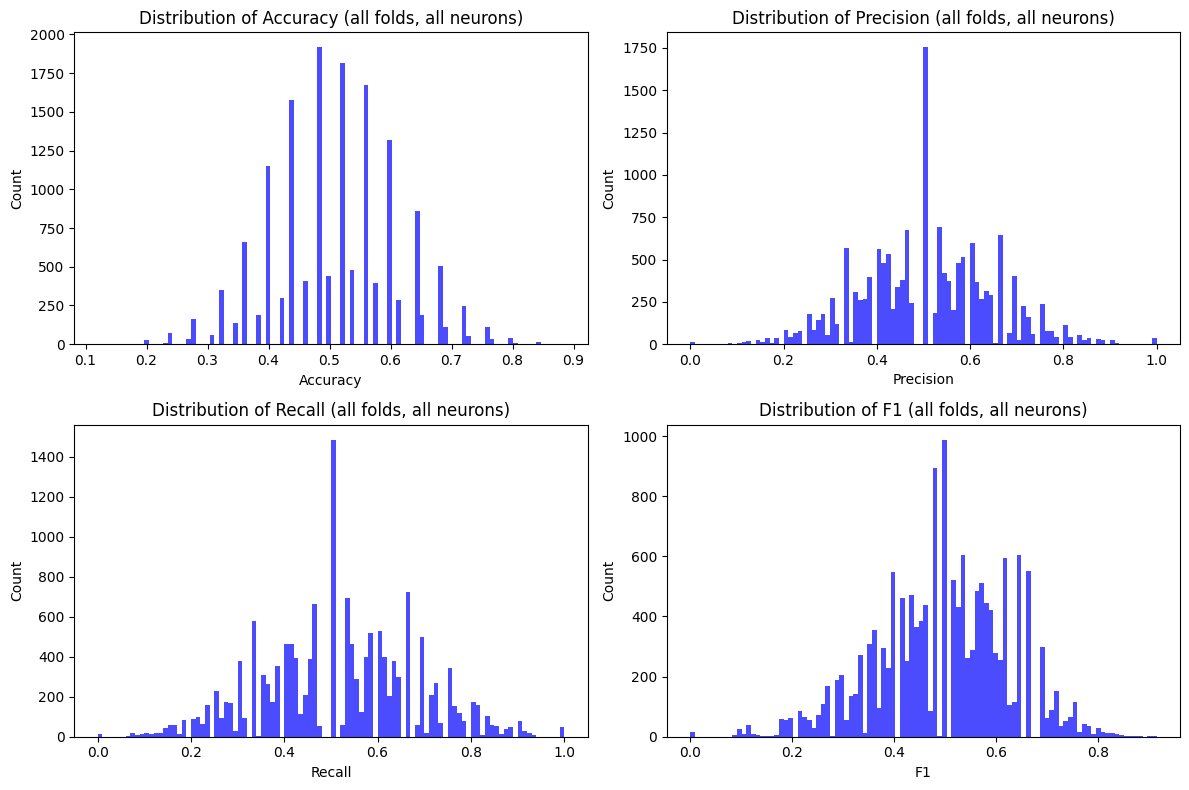

In [15]:
X_all = np.concatenate([mean_activity_cs_1[:-1, ], mean_activity_cs_2[:-1, ]])
y_1 = np.diff(mean_activity_cs_1, axis=0)
y_2 = np.diff(mean_activity_cs_2, axis=0)
y_all = np.concatenate([y_1, y_2])

sign_changes = np.where(y_all > 0, 1, -1)
print(sign_changes)

#raw SERt-1 data (in SER space)
LR_model(X_all, sign_changes)

X_all shape: (248, 3124), y_all shape: (248, 3124)

=== Cross-Validation Summary ===
Accuracy:  0.396 ± 0.062
Precision: 0.395
Recall:    0.397
F1-score:  0.390


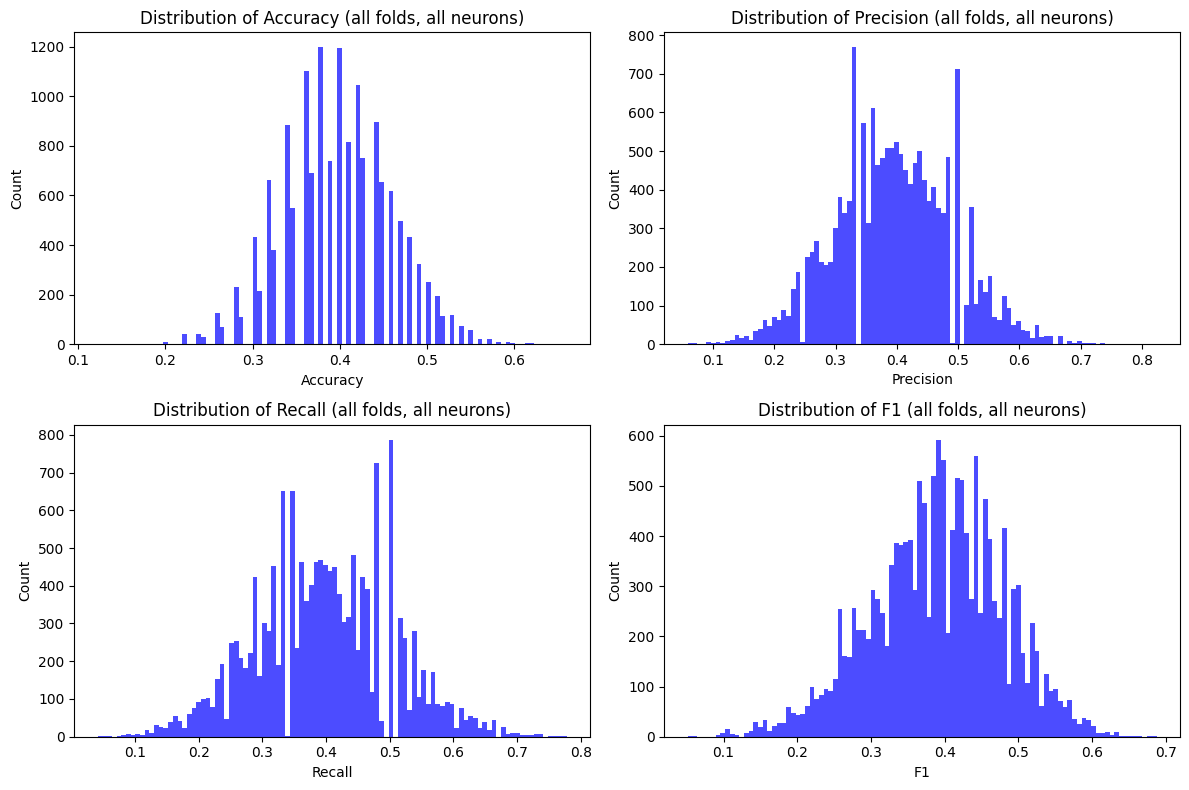

In [ ]:
X_cs_1, y_cs_1_clean = clean_and_prepare_data(mean_activity_r_1, mean_activity_cs_1, trial_r_1)
X_cs_2, y_cs_2_clean = clean_and_prepare_data(mean_activity_r_2, mean_activity_cs_2, trial_r_2)

X_cs_1_diff = np.diff(mean_activity_r_1, axis=0)
X_cs_2_diff = np.diff(mean_activity_r_2, axis=0)

X_all = np.concatenate([X_cs_1_diff, X_cs_2_diff])  # Shape: (total_reactivations -2, neurons)
y_all = np.concatenate([y_cs_1_clean[:-1, ], y_cs_2_clean[:-1, ]]) 

#Ri - Ri-1 (in reactivation space)
LR_model(X_all, y_all)



X_all shape: (250, 3124), y_all shape: (250, 3124)

=== Cross-Validation Summary ===
Accuracy:  0.545 ± 0.071
Precision: 0.546
Recall:    0.540
F1-score:  0.535


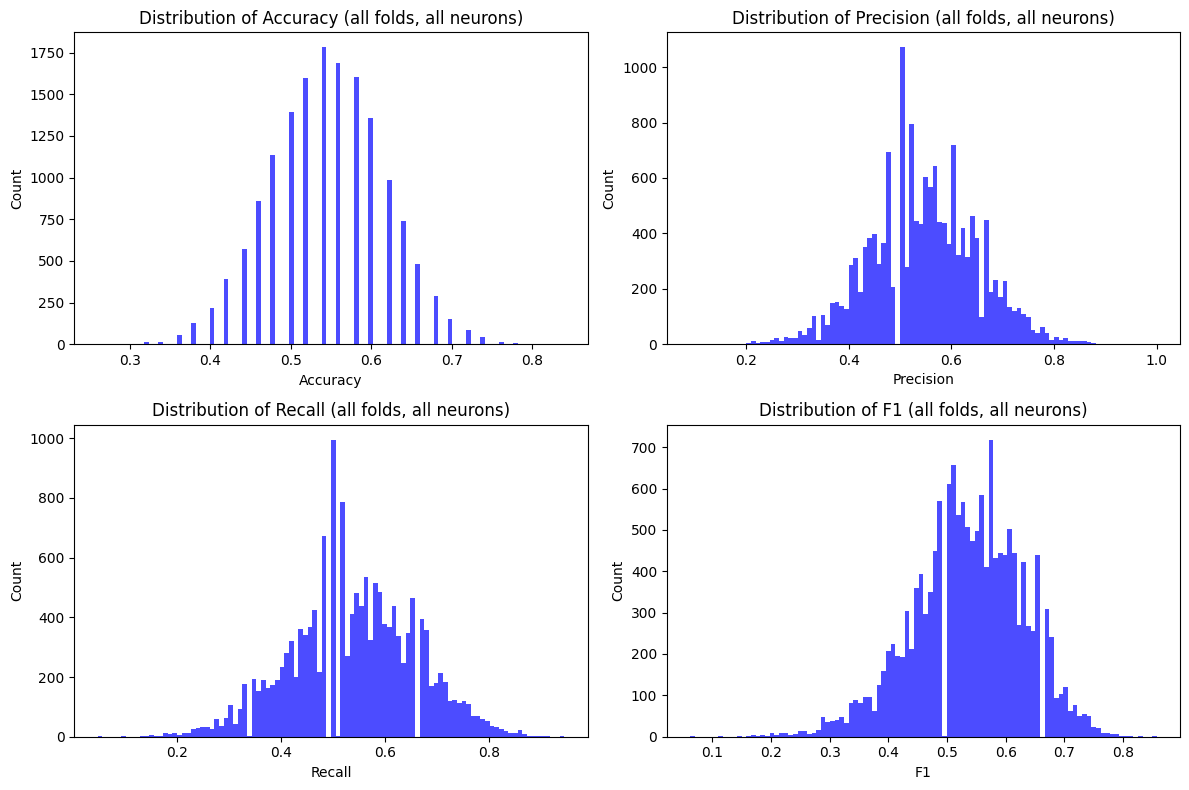

In [ ]:
X_cs_1, y_cs_1_clean = clean_and_prepare_data(mean_activity_r_1, mean_activity_cs_1, trial_r_1)
X_cs_2, y_cs_2_clean = clean_and_prepare_data(mean_activity_r_2, mean_activity_cs_2, trial_r_2)

X_all = np.concatenate([mean_activity_r_1, mean_activity_r_2])  # Shape: (total_reactivations, neurons)
y_all = np.concatenate([y_cs_1_clean, y_cs_2_clean]) 

#raw reactivation data (projected in reactivation space)
LR_model(X_all, y_all)



[[ 1  1 -1 ... -1  1 -1]
 [ 1 -1  1 ...  1 -1 -1]
 [-1  1 -1 ... -1 -1 -1]
 ...
 [-1  1  1 ... -1 -1  1]
 [-1 -1 -1 ...  1  1 -1]
 [ 1  1  1 ... -1 -1  1]]
X_all shape: (124, 3124), y_all shape: (124, 3124)



=== Cross-Validation Summary ===
Accuracy:  0.656 ± 0.095
Precision: 0.656
Recall:    0.660
F1-score:  0.646


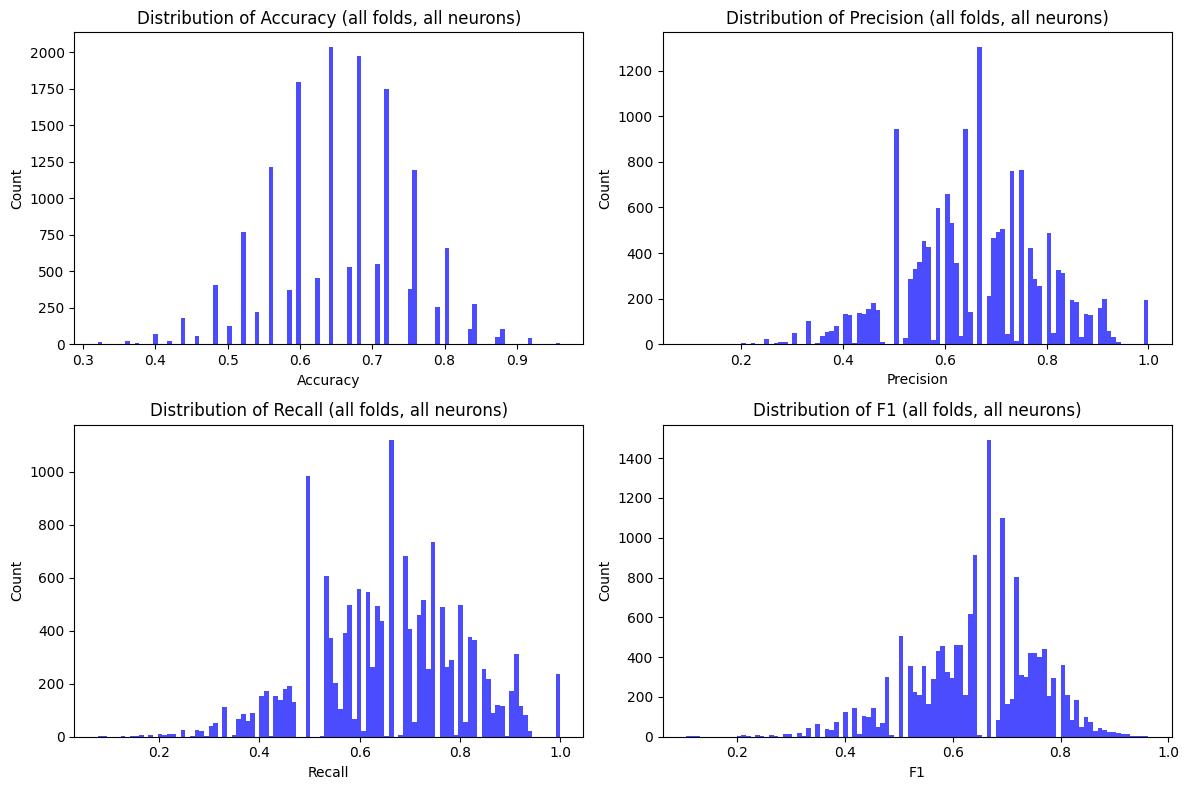

In [20]:
x_1 = np.diff(mean_activity_cs_1, axis= 0)
x_2 = np.diff(mean_activity_cs_2, axis=0)

X_all = np.concatenate([x_1[:-1, ], x_2[:-1, ]])
y_1 = np.diff(mean_activity_cs_1, axis=0)
y_2 = np.diff(mean_activity_cs_2, axis=0)
#taget SERt+1
y_all = np.concatenate([y_1[1:, ], y_2[1:, ]])

sign_changes = np.where(y_all > 0, 1, -1)
print(sign_changes)

#SERt - SERt-1
LR_model(X_all, sign_changes)

# Analysis predicting raw activity using simple linear regression

(250, 3124) (250, 3124)


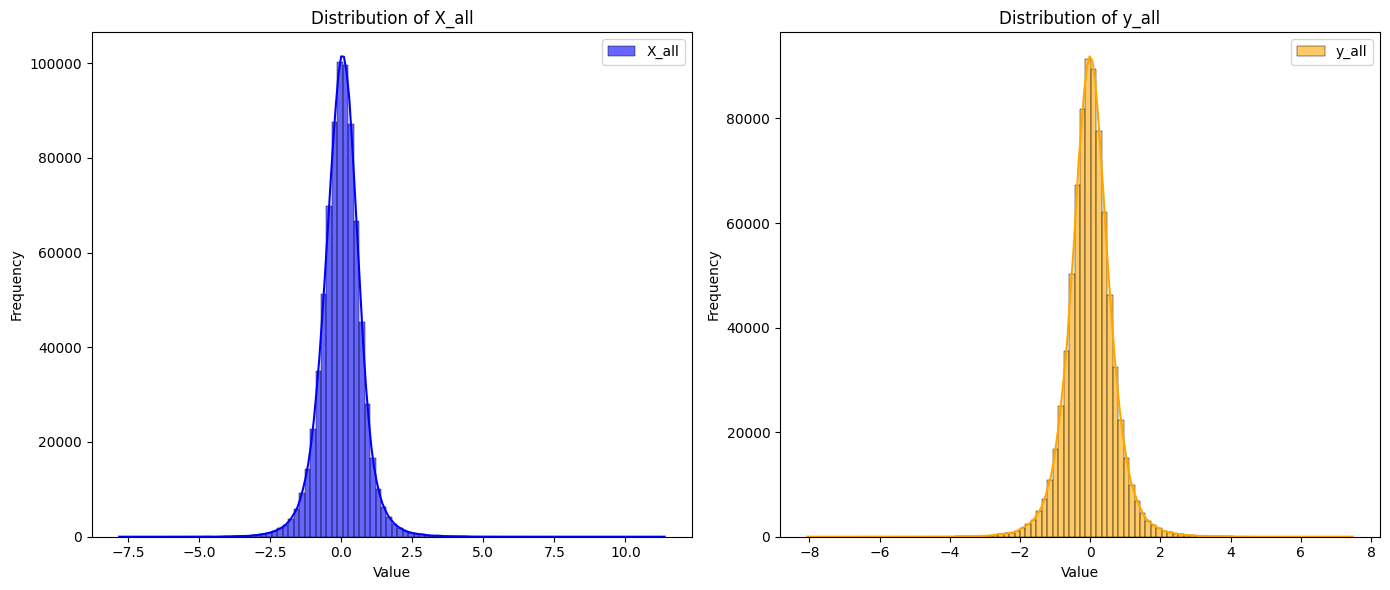

In [112]:
def compute_sign_changes_linearR(mean_activity_cs, trial_r):
    """
    Compute sign changes based on trial-to-trial differences and map them to reactivations.
    
    Parameters:
    - mean_activity_cs: Trial-level activity (shape: trials x neurons)
    - trial_r: Reactivation-to-trial mapping (shape: reactivations,)
    
    Returns:
    - sign_changes: Array of sign changes mapped to reactivations (-1 or +1) for each neuron wrt the next SER trial.
    """
    
    # Compute trial-to-trial differences
    trial_diff = np.diff(mean_activity_cs, axis=0)  # Shape: (trials-1, neurons)

    # Compute signs of trial differences
    #trial_sign_changes = np.where(trial_diff > 0, 1, -1)  # Shape: (trials-1, neurons)

    # Map trial-level changes to reactivations
    #reactivation_sign_changes = trial_sign_changes[trial_r] 
    reactivation_sign_changes = trial_diff[trial_r] 


    return reactivation_sign_changes

def clean_and_prepare_data_linearR(mean_activity_r, mean_activity_cs, trial_r):
    """
    Prepare predictors (X) and targets (y) for logistic regression
    
    Parameters:
    - mean_activity_r: Reactivation-level activity (shape: reactivations x neurons)
    - mean_activity_cs: Trial-level activity (shape: trials x neurons)
    - trial_r: Reactivation-to-trial mapping (shape: reactivations,)
    
    Returns:
    - X_all: Combined predictors (reactivation activity) for sensory evoked response (shape: total_reactivations, neurons).
    - y_all: Combined targets (sign changes) for all neurons (shape: total_reactivations, neurons).
    """
    X_list = []  # Predictors for all neurons
    y_list = []  # Targets for all neurons
    
    # Compute targets for all neurons
    for neuron in range(mean_activity_cs_1.shape[1]):
        y_neuron = compute_sign_changes(mean_activity_cs[:, neuron], trial_r)
        y_list.append(y_neuron)

    # Prepare predictors for the subset of neurons
    for neuron in range(mean_activity_r.shape[1]):
        # Adjust reactivation activity by subtracting the SER activity
        X_neuron = mean_activity_r[:, neuron] - mean_activity_cs[trial_r, neuron]
        X_list.append(X_neuron)
    
    # Stack all predictors and targets
    X_all = np.column_stack(X_list)  # Shape: (total_reactivations, subset_neurons)
    y_all = np.column_stack(y_list)  # Shape: (total_reactivations, total_neurons)
        
    return X_all, y_all

def plot_distributions(X_all, y_all, alpha_value=0.6, bins=100):
    
    # Flatten the arrays to analyze distributions across all neurons/reactivations
    X_flat = X_all.flatten()
    y_flat = y_all.flatten()
    
    plt.figure(figsize=(14, 6))

    # Plot distribution of X_all
    plt.subplot(1, 2, 1)
    sns.histplot(X_flat, kde=True, color='blue', bins=bins, alpha=alpha_value, label='X_all')
    plt.title('Distribution of X_all')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Plot distribution of y_all
    plt.subplot(1, 2, 2)
    sns.histplot(y_flat, kde=True, color='orange', bins=bins, alpha=alpha_value, label='y_all')
    plt.title('Distribution of y_all')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()

X_cs_1, y_cs_1_clean = clean_and_prepare_data(mean_activity_r_1, mean_activity_cs_1, trial_r_1)
X_cs_2, y_cs_2_clean = clean_and_prepare_data(mean_activity_r_2, mean_activity_cs_2, trial_r_2)


# Combine the datasets
X_all = np.concatenate([X_cs_1, X_cs_2])  # Shape: (total_reactivations, neurons)
y_all = np.concatenate([y_cs_1_clean, y_cs_2_clean]) 

print(X_all.shape, y_all.shape)
plot_distributions(X_all, y_all)





X_all shape: (250, 3124), y_all shape: (250, 3124)

=== Cross-Validation Summary ===
Mean Absolute Error (MAE): 0.287 ± 0.085
Mean Squared Error (MSE): 0.181
Root Mean Squared Error (RMSE): 0.404
R-squared Score (R²): 0.563


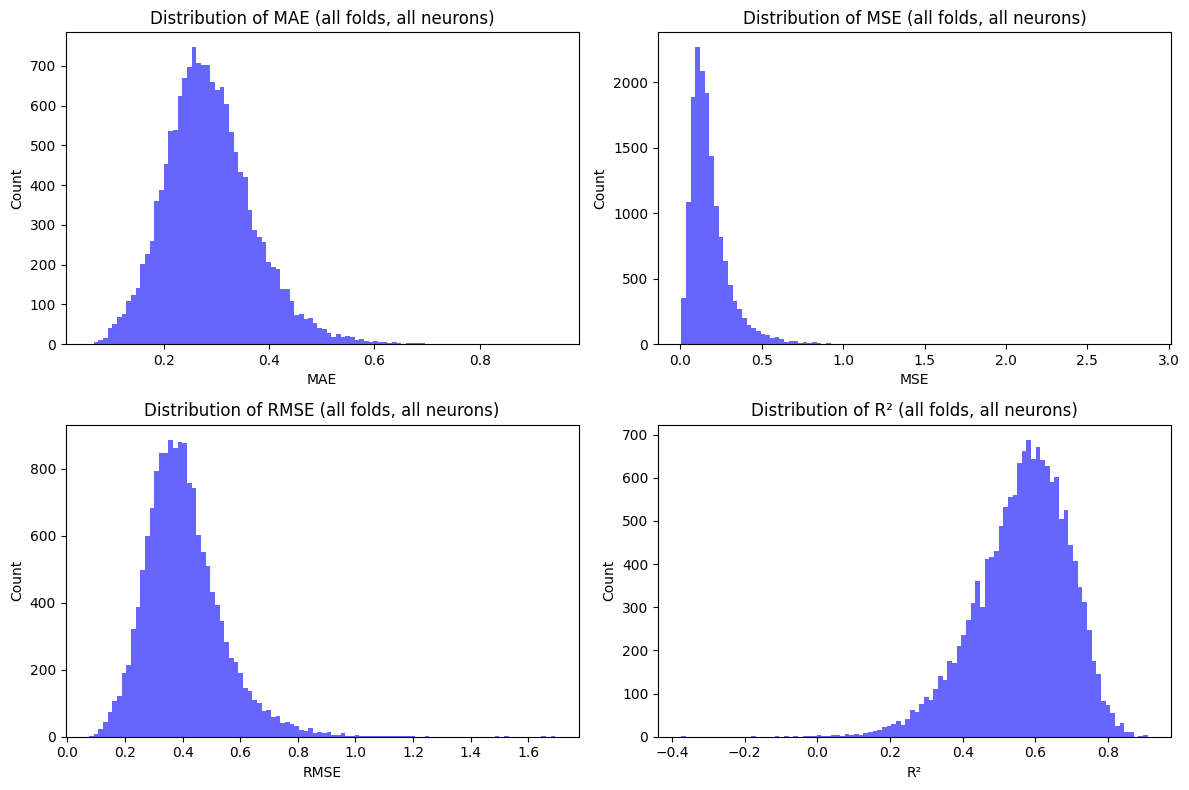

In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

def evaluate_fold(model, X_train, X_test, y_train, y_test):
    """Trains the linear regression model and evaluates metrics for a single CV fold."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Compute regression metrics for each output (neuron)
    fold_maes = []
    fold_mses = []
    fold_rmses = []
    fold_r2s = []

    for neuron_idx in range(y_test.shape[1]):
        y_test_n = y_test[:, neuron_idx]
        y_pred_n = y_pred[:, neuron_idx]

        fold_maes.append(mean_absolute_error(y_test_n, y_pred_n))
        fold_mses.append(mean_squared_error(y_test_n, y_pred_n))
        fold_rmses.append(np.sqrt(mean_squared_error(y_test_n, y_pred_n)))
        fold_r2s.append(r2_score(y_test_n, y_pred_n))

    return fold_maes, fold_mses, fold_rmses, fold_r2s

def LinearRegression_model(X_all, y_all):
    print(f"X_all shape: {X_all.shape}, y_all shape: {y_all.shape}")

    # Initialize KFold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Model initialization
    model_cv = LinearRegression()

    # Aggregate results using parallel processing
    all_results = Parallel(n_jobs=-1)(delayed(evaluate_fold)(
        model_cv, 
        X_all[train_idx], X_all[test_idx], 
        y_all[train_idx], y_all[test_idx]
    ) for train_idx, test_idx in kf.split(X_all))

    # Unpack results
    all_maes, all_mses, all_rmses, all_r2s = zip(*all_results)
    all_maes = np.concatenate(all_maes)
    all_mses = np.concatenate(all_mses)
    all_rmses = np.concatenate(all_rmses)
    all_r2s = np.concatenate(all_r2s)

    # Summary of cross-validation results
    print("\n=== Cross-Validation Summary ===")
    print(f"Mean Absolute Error (MAE): {np.mean(all_maes):.3f} ± {np.std(all_maes):.3f}")
    print(f"Mean Squared Error (MSE): {np.mean(all_mses):.3f}")
    print(f"Root Mean Squared Error (RMSE): {np.mean(all_rmses):.3f}")
    print(f"R-squared Score (R²): {np.mean(all_r2s):.3f}")

    # Create dictionary of metric values
    metrics_dict = {
        "MAE": all_maes,
        "MSE": all_mses,
        "RMSE": all_rmses,
        "R²": all_r2s
    }

    # Plot the distribution of each metric
    plt.figure(figsize=(12, 8))
    for i, (metric_name, values) in enumerate(metrics_dict.items()):
        plt.subplot(2, 2, i+1)
        plt.hist(values, bins=100, alpha=0.6, color='b')
        plt.title(f"Distribution of {metric_name} (all folds, all neurons)")
        plt.xlabel(metric_name)
        plt.ylabel("Count")

    plt.tight_layout()
    plt.show()

#Ri - SERt (projected in reactivation space)
LinearRegression_model(X_all, y_all)


(68, 3124)
(60, 3124)
(126, 3124)


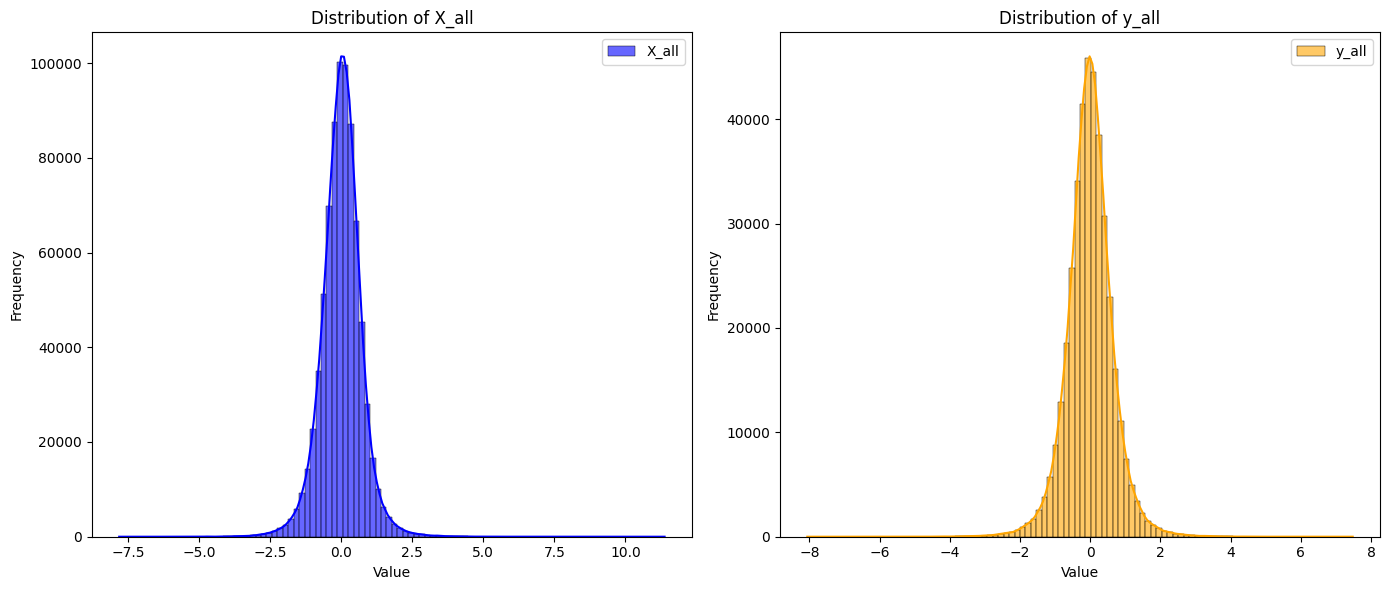

X_all shape: (126, 3124), y_all shape: (126, 3124)

=== Cross-Validation Summary ===
Mean Absolute Error (MAE): 0.511 ± 0.149
Mean Squared Error (MSE): 0.472
Root Mean Squared Error (RMSE): 0.656
R-squared Score (R²): -0.145


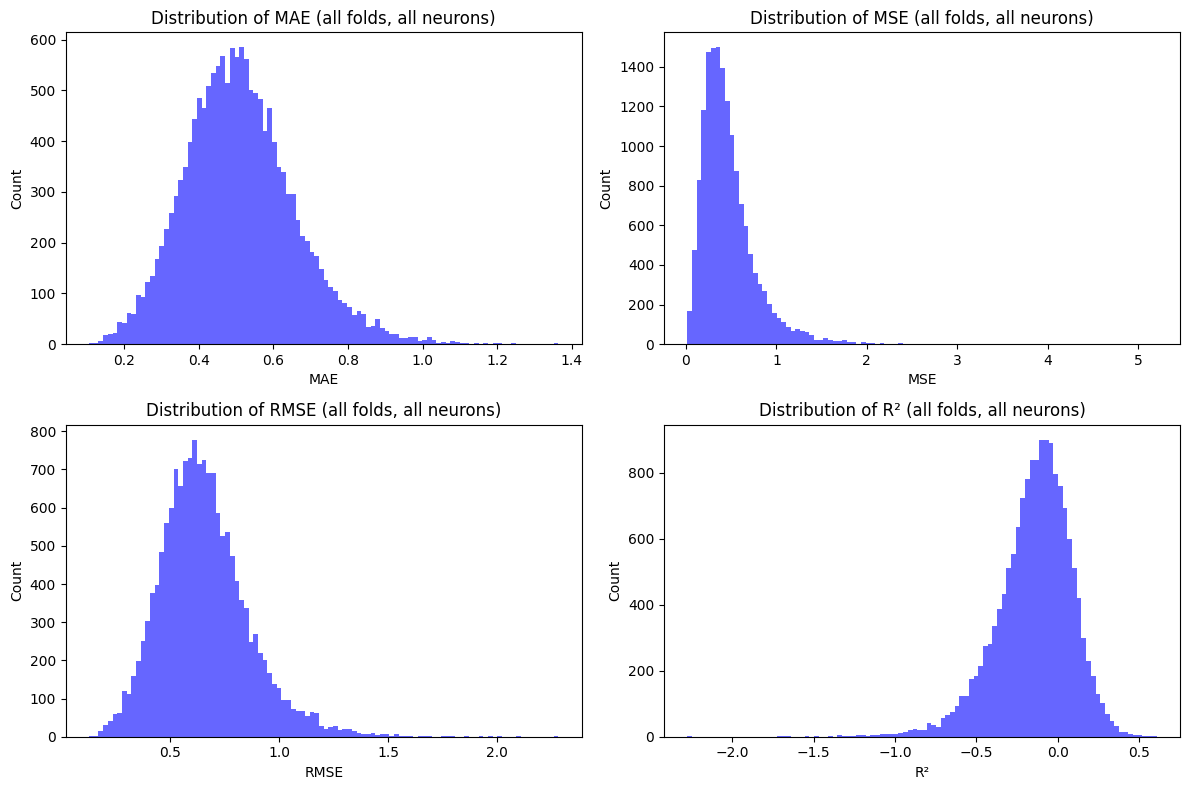

In [49]:
X_1 = mean_mean_activity_r1 - mean_activity_cs_1
print(X_1.shape)
X_2 = mean_mean_activity_r2 - mean_activity_cs_2
print(X_2.shape)
x_all = np.concatenate([X_1[:-1, ], X_2[:-1, ]])
print(x_all.shape)

y_1 = np.diff(mean_activity_cs_1, axis=0)
y_2 = np.diff(mean_activity_cs_2, axis=0)

y_all = np.concatenate([y_1, y_2])

plot_distributions(X_all, y_all)


#Ri - SERt-1 (compressed in SER space)
LinearRegression_model(x_all, y_all)


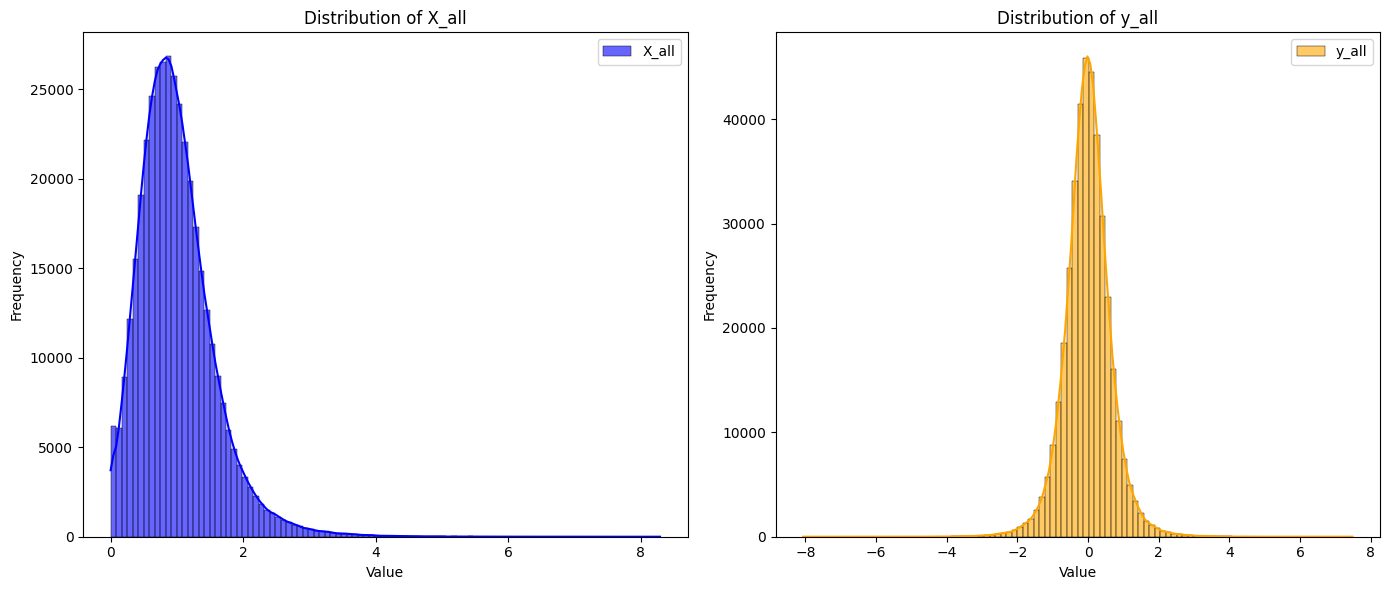

X_all shape: (126, 3124), y_all shape: (126, 3124)

=== Cross-Validation Summary ===
Mean Absolute Error (MAE): 0.518 ± 0.152
Mean Squared Error (MSE): 0.486
Root Mean Squared Error (RMSE): 0.665
R-squared Score (R²): -0.178


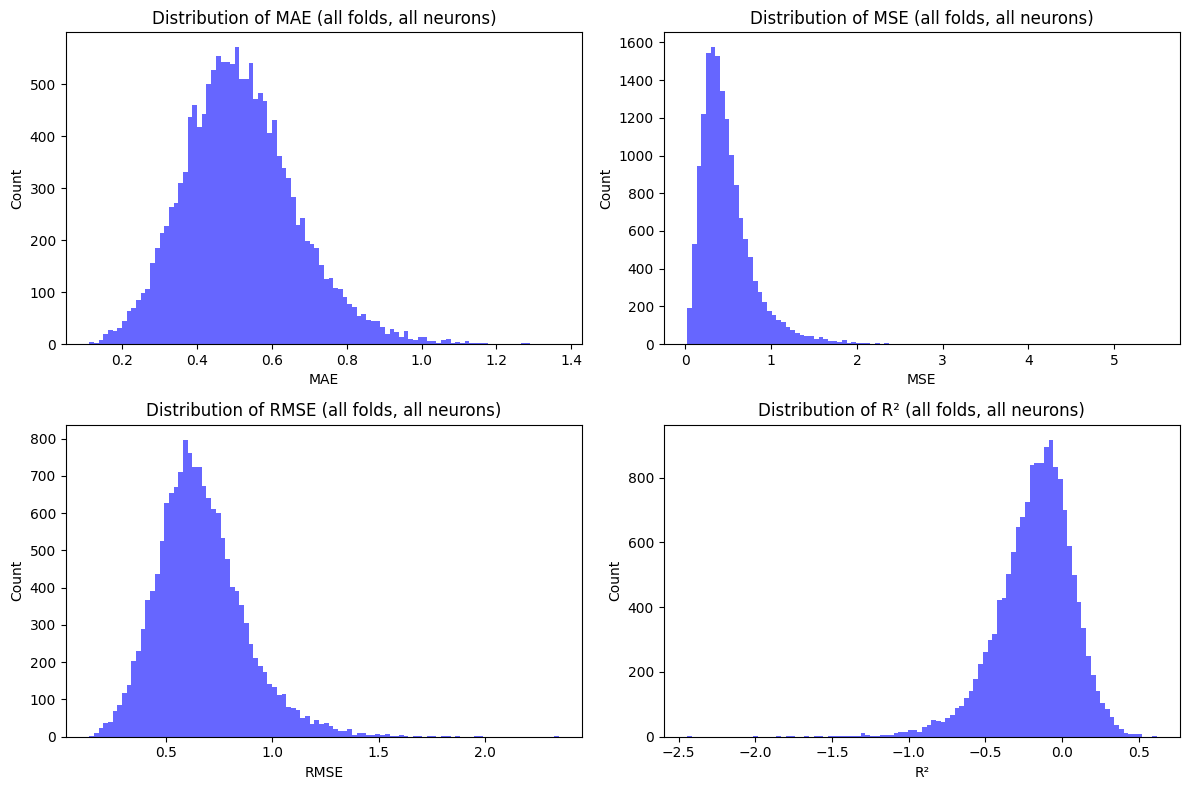

In [51]:
X_all = np.concatenate([mean_activity_cs_1[:-1, ], mean_activity_cs_2[:-1, ]])
y_1 = np.diff(mean_activity_cs_1, axis=0)
y_2 = np.diff(mean_activity_cs_2, axis=0)
y_all = np.concatenate([y_1, y_2])

plot_distributions(X_all, y_all)
#raw SERt-1 data (in SER space)
LinearRegression_model(X_all, y_all)

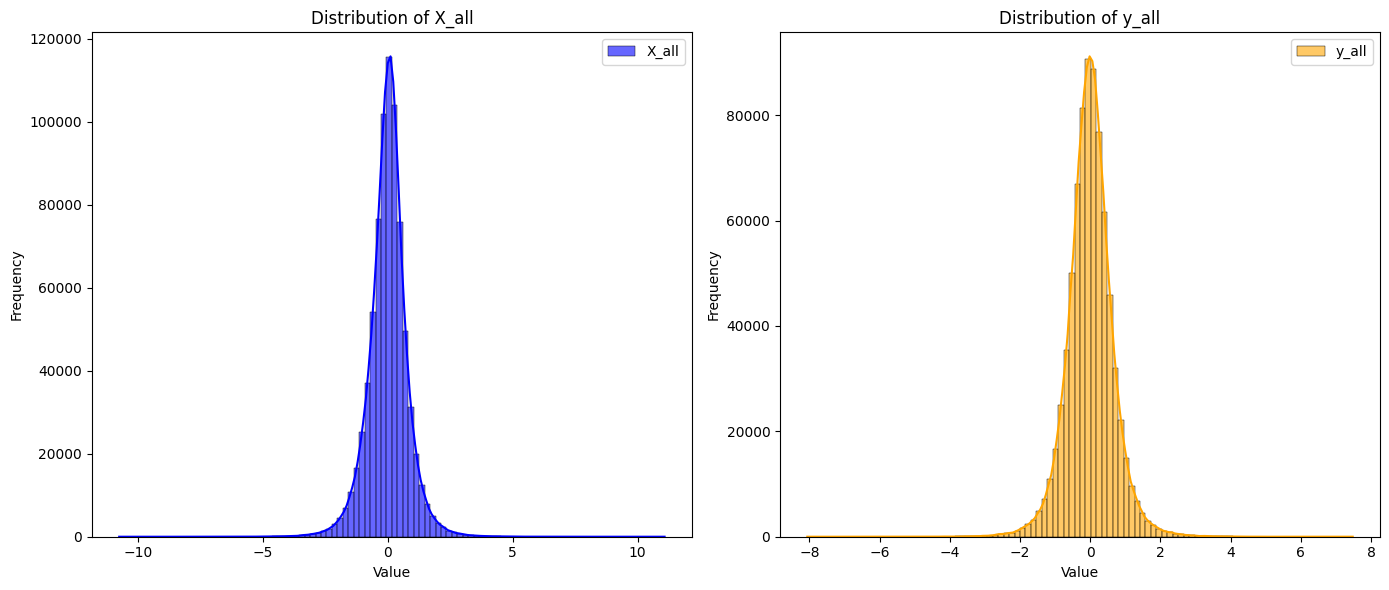

[1, 1, 1, 2, 2, 2, 3, 3, 4, 5, 5, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21, 21, 21, 23, 24, 25, 25, 26, 26, 27, 28, 29, 29, 29, 30, 30, 30, 30, 31, 33, 34, 34, 34, 35, 36, 37, 38, 39, 39, 40, 40, 41, 41, 42, 42, 43, 44, 44, 45, 45, 46, 47, 48, 50, 51, 52, 52, 52, 53, 53, 54, 54, 54, 55, 55, 55, 55, 56, 57, 57, 57, 57, 58, 58, 58, 58, 58, 59, 59, 59, 60, 60, 61, 61, 61, 62, 62, 62, 62, 63, 63, 64, 64, 64, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66]
X_all shape: (248, 3124), y_all shape: (248, 3124)

=== Cross-Validation Summary ===
Mean Absolute Error (MAE): 0.814 ± 0.237
Mean Squared Error (MSE): 1.323
Root Mean Squared Error (RMSE): 1.096
R-squared Score (R²): -2.218


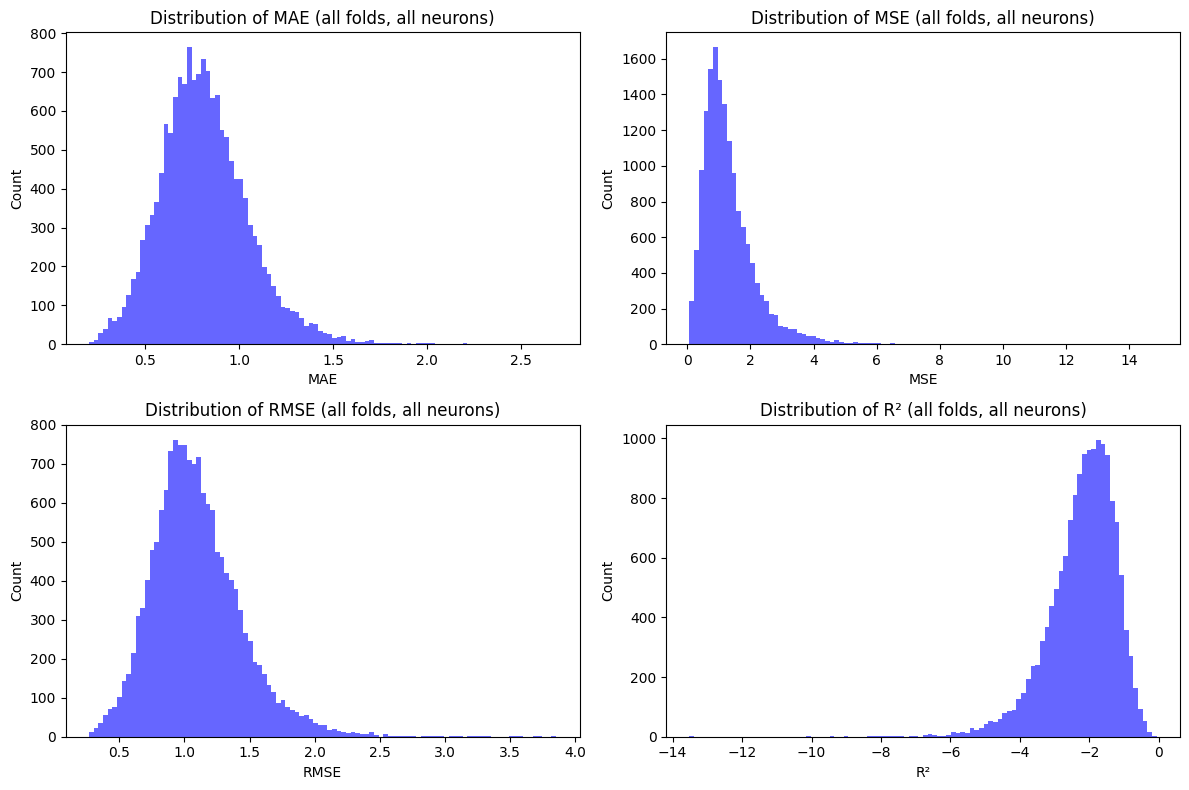

In [66]:
X_cs_1, y_cs_1_clean = clean_and_prepare_data_linearR(mean_activity_r_1, mean_activity_cs_1, trial_r_1)
X_cs_2, y_cs_2_clean = clean_and_prepare_data_linearR(mean_activity_r_2, mean_activity_cs_2, trial_r_2)

X_cs_1_diff = np.diff(X_cs_1, axis=0)
X_cs_2_diff = np.diff(X_cs_2, axis=0)

X_all = np.concatenate([X_cs_1_diff, X_cs_2_diff])  # Shape: (total_reactivations, neurons)
y_all = np.concatenate([y_cs_1_clean[:-1, ], y_cs_2_clean[:-1, ]]) 
plot_distributions(X_all, y_all)

print(trial_r_1)
#Ri - Ri-1 (in reactivation space)
LinearRegression_model(X_all, y_all)



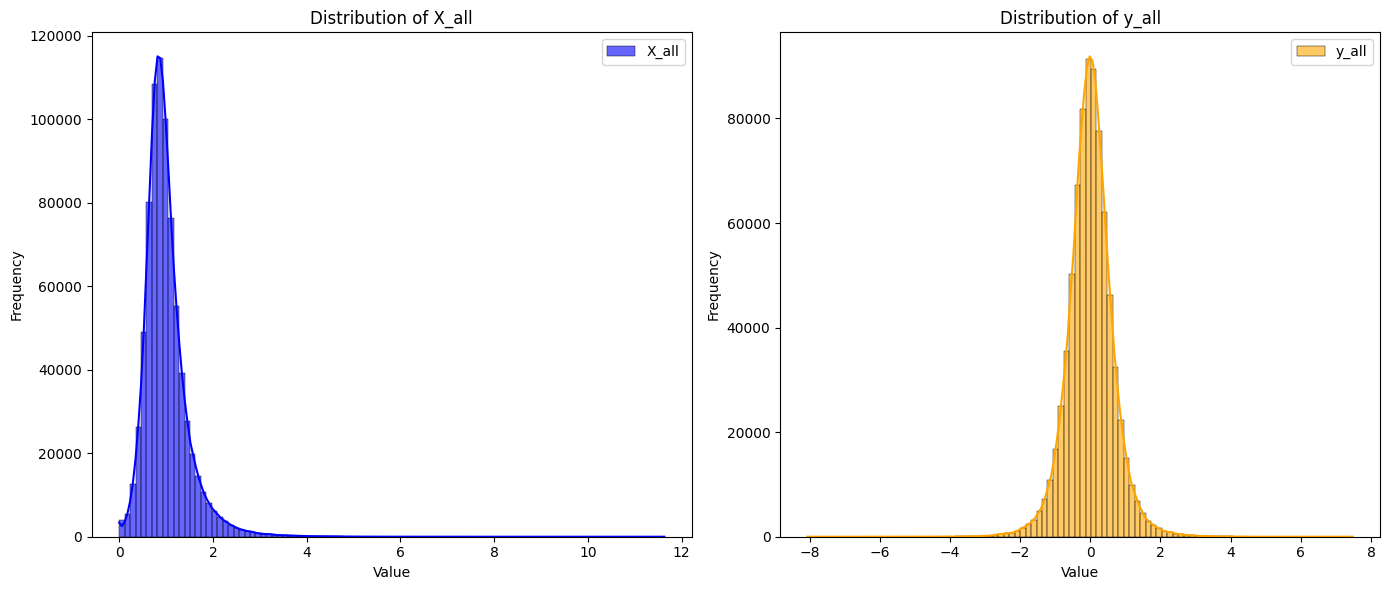

X_all shape: (250, 3124), y_all shape: (250, 3124)

=== Cross-Validation Summary ===
Mean Absolute Error (MAE): 0.543 ± 0.156
Mean Squared Error (MSE): 0.528
Root Mean Squared Error (RMSE): 0.695
R-squared Score (R²): -0.273


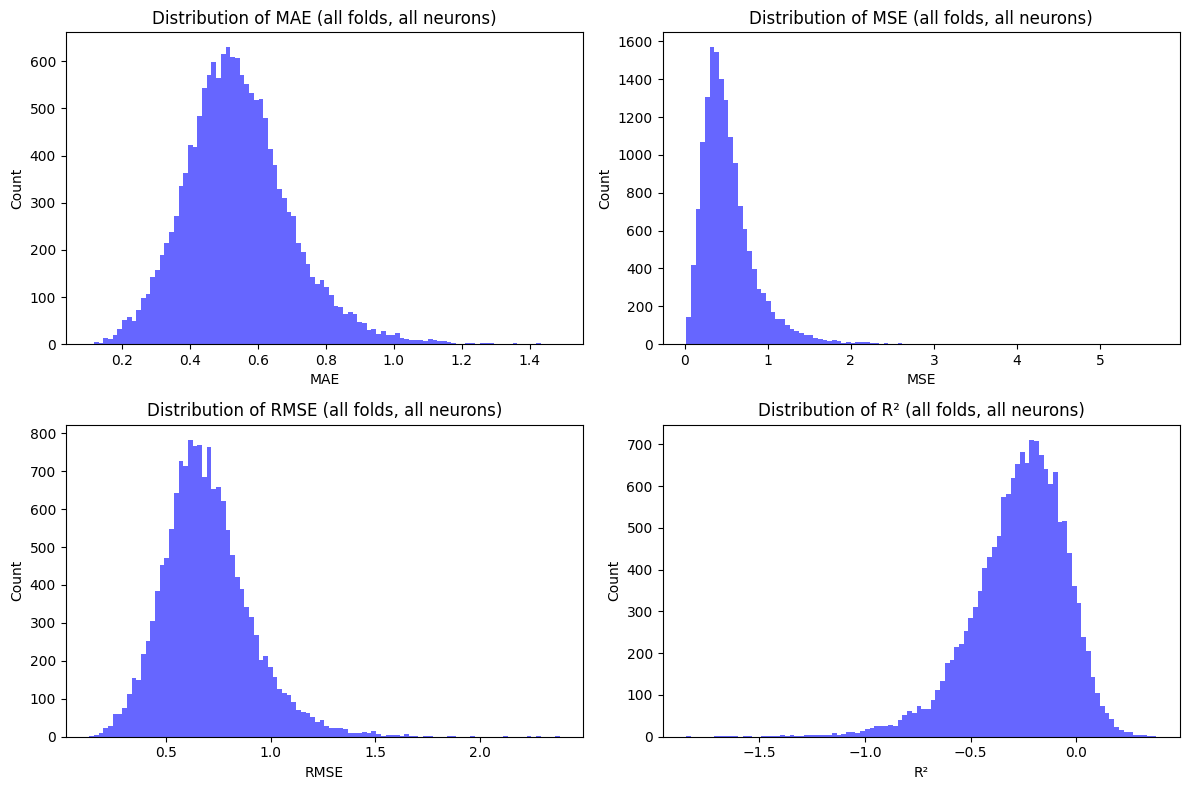

In [59]:
X_cs_1, y_cs_1_clean = clean_and_prepare_data_linearR(mean_activity_r_1, mean_activity_cs_1, trial_r_1)
X_cs_2, y_cs_2_clean = clean_and_prepare_data_linearR(mean_activity_r_2, mean_activity_cs_2, trial_r_2)

X_cs_1_diff = np.diff(X_cs_1, axis=0)
X_cs_2_diff = np.diff(X_cs_2, axis=0)

X_all = np.concatenate([mean_activity_r_1, mean_activity_r_2])  # Shape: (total_reactivations, neurons)
y_all = np.concatenate([y_cs_1_clean, y_cs_2_clean]) 
plot_distributions(X_all, y_all)

#raw reactivation data (projected in reactivation space)
LinearRegression_model(X_all, y_all)



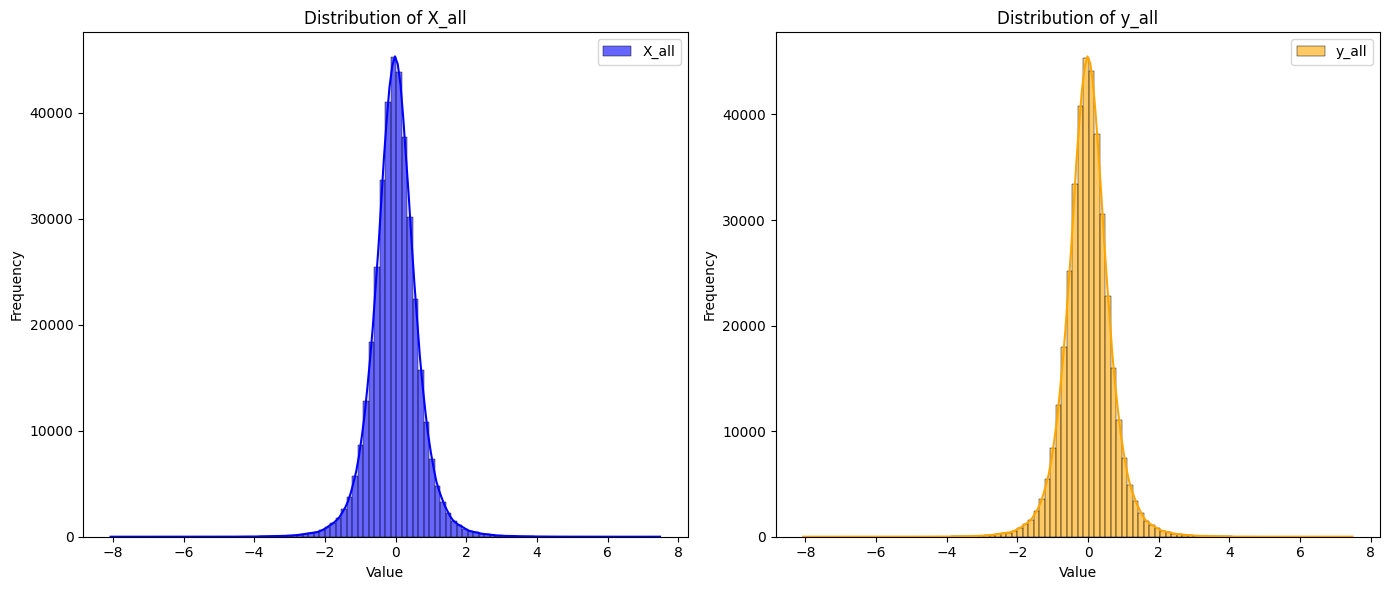

X_all shape: (124, 3124), y_all shape: (124, 3124)

=== Cross-Validation Summary ===
Mean Absolute Error (MAE): 0.360 ± 0.114
Mean Squared Error (MSE): 0.241
Root Mean Squared Error (RMSE): 0.464
R-squared Score (R²): 0.399


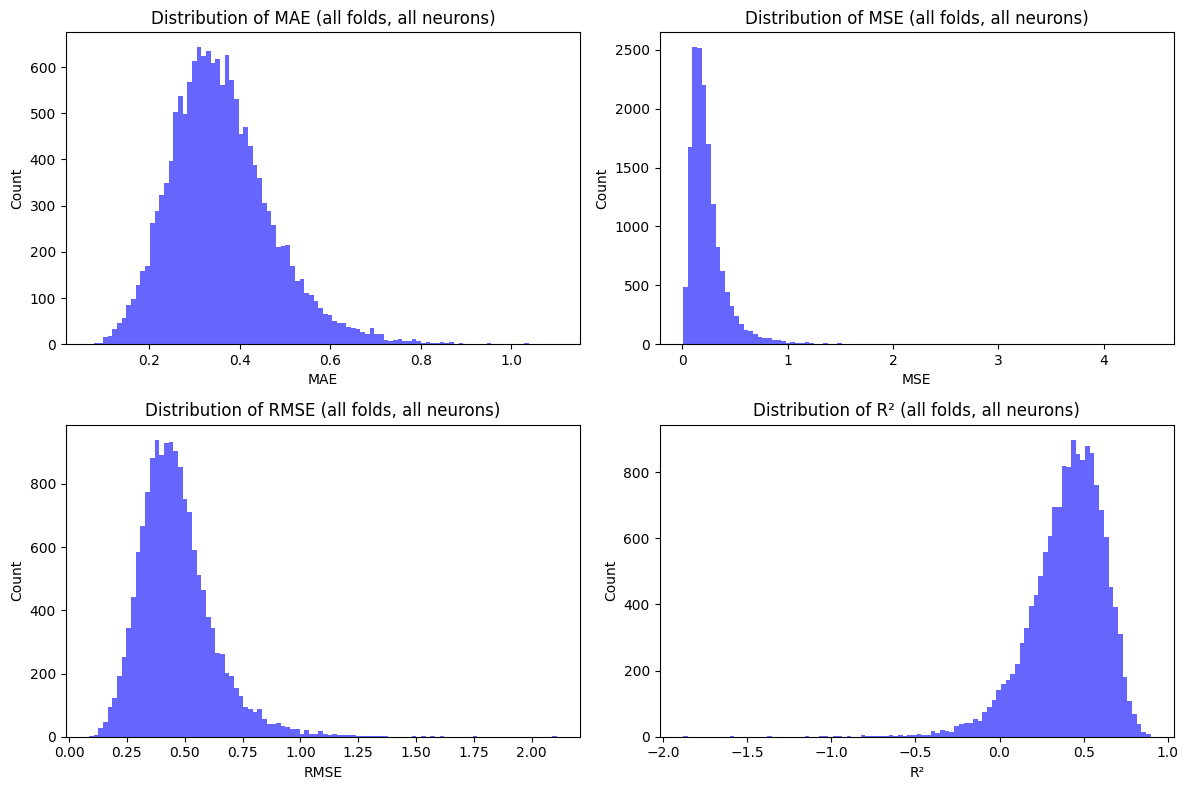

In [81]:
x_1 = np.diff(mean_activity_cs_1, axis= 0)
x_2 = np.diff(mean_activity_cs_2, axis=0)

X_all = np.concatenate([x_1[:-1, ], x_2[:-1, ]])
y_1 = np.diff(mean_activity_cs_1, axis=0)
y_2 = np.diff(mean_activity_cs_2, axis=0)
#taget SERt+1
y_all = np.concatenate([y_1[1:, ], y_2[1:, ]])
plot_distributions(X_all, y_all)

#SERt - SERt-1
LinearRegression_model(X_all, y_all)

# Predicting sign of change with cumulative reactivation data

In [12]:
def clean_and_prepare_data_cumulative(mean_activity_r, mean_activity_cs, trial_r):
    """
    Prepare cumulative predictors (X) and targets (y) for logistic regression
    
    Parameters:
    - mean_activity_r: Reactivation-level activity (shape: reactivations x neurons)
    - mean_activity_cs: Trial-level activity (shape: trials x neurons)
    - trial_r: Reactivation-to-trial mapping (shape: reactivations,)
    
    Returns:
    - X_all: Cumulative predictors (cumulative reactivation activity) for sensory evoked response (shape: total_reactivations, neurons).
    - y_all: Targets (sign changes) for all neurons (shape: total_reactivations, neurons).
    """
    X_list = []  # Predictors for all neurons
    y_list = []  # Targets for all neurons
    
    # Compute targets for all neurons (no change to this logic)
    for neuron in range(mean_activity_cs.shape[1]):
        y_neuron = compute_sign_changes(mean_activity_cs[:, neuron], trial_r)
        y_list.append(y_neuron)

    # Compute cumulative predictors for the subset of neurons
    for neuron in range(mean_activity_r.shape[1]):
        # Compute cumulative sum of reactivation activity over time
        X_neuron_cumulative = np.cumsum(mean_activity_r[:, neuron]) 

        # Adjust by subtracting the corresponding SER trial activity
        X_neuron_adjusted = X_neuron_cumulative - mean_activity_cs[trial_r, neuron]

        X_list.append(X_neuron_adjusted)
    
    # Stack all cumulative predictors and targets
    X_all = np.column_stack(X_list)  # Shape: (total_reactivations, subset_neurons)
    y_all = np.column_stack(y_list)  # Shape: (total_reactivations, total_neurons)
        
    return X_all, y_all

X_cs_1, y_cs_1_clean = clean_and_prepare_data_cumulative(mean_activity_r_1, mean_activity_cs_1, trial_r_1)
X_cs_2, y_cs_2_clean = clean_and_prepare_data_cumulative(mean_activity_r_2, mean_activity_cs_2, trial_r_2)

# Combine the datasets
X_all = np.concatenate([X_cs_1, X_cs_2])  # Shape: (total_reactivations, neurons)
y_all = np.concatenate([y_cs_1_clean, y_cs_2_clean]) 

print(X_all.shape, y_all.shape)

# Sanity check the processed targets
unique_cs_1, counts_cs_1 = np.unique(y_cs_1_clean, return_counts=True)
unique_cs_2, counts_cs_2 = np.unique(y_cs_2_clean, return_counts=True)

print("Processed Targets for CS_1:")
print(dict(zip(unique_cs_1, counts_cs_1)))
print("\nProcessed Targets for CS_2:")
print(dict(zip(unique_cs_2, counts_cs_2)))


(250, 3124) (250, 3124)
Processed Targets for CS_1:
{-1: 216563, 1: 217673}

Processed Targets for CS_2:
{-1: 173997, 1: 172767}


X_all shape: (250, 3124), y_all shape: (250, 3124)



=== Cross-Validation Summary ===
Accuracy:  0.690 ± 0.064
Precision: 0.692
Recall:    0.689
F1-score:  0.684


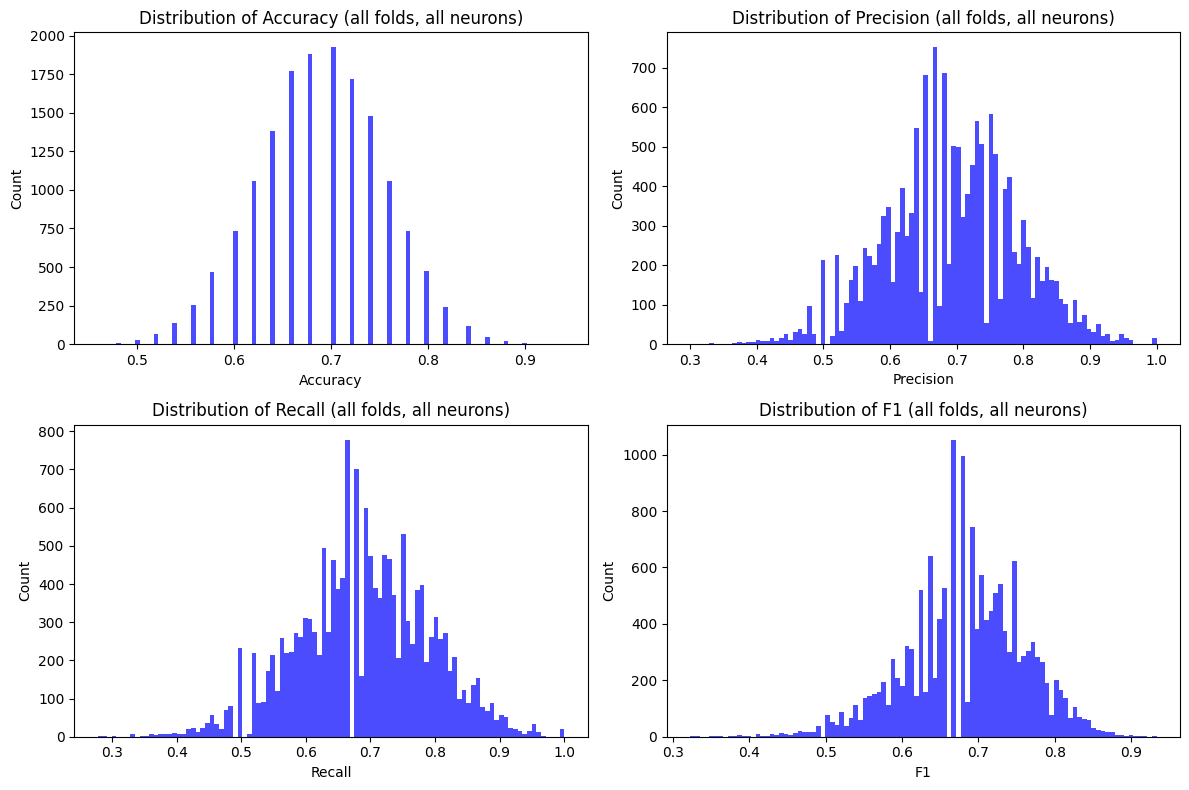

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)  # Scale cumulative predictors

#Ri - SERt-1 (projected in reactivation space, cumulative reactivation data)

LR_model(X_all_scaled, y_all)

X_all shape: (250, 3124), y_all shape: (250, 3124)

=== Cross-Validation Summary ===
Accuracy:  0.591 ± 0.068
Precision: 0.594
Recall:    0.591
F1-score:  0.585


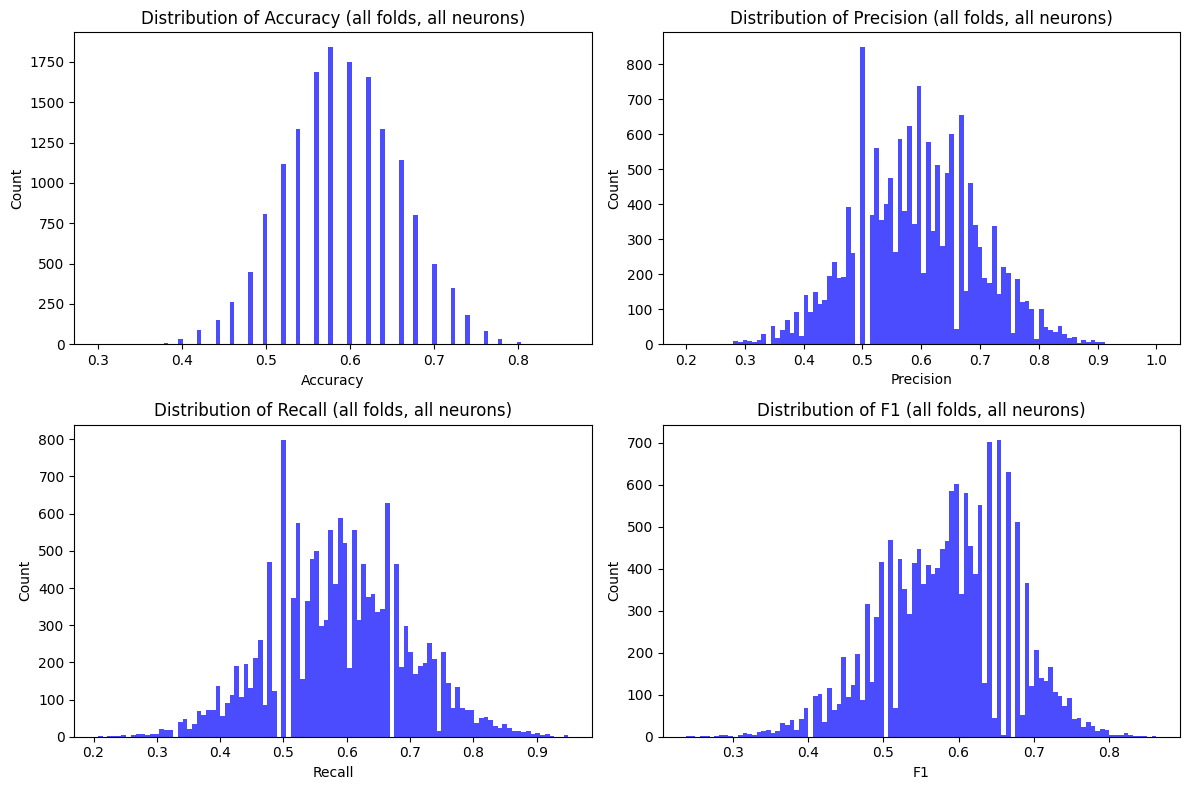

In [15]:
X_cs_1, y_cs_1_clean = clean_and_prepare_data(mean_activity_r_1, mean_activity_cs_1, trial_r_1)
X_cs_2, y_cs_2_clean = clean_and_prepare_data(mean_activity_r_2, mean_activity_cs_2, trial_r_2)

cum_r1 = np.cumsum(mean_activity_r_1, axis=0)
cum_r2 = np.cumsum(mean_activity_r_2, axis=0)



X_all = np.concatenate([cum_r1, cum_r2])  # Shape: (total_reactivations, neurons)
y_all = np.concatenate([y_cs_1_clean, y_cs_2_clean]) 

X_all_scaled = scaler.fit_transform(X_all)  # Scale cumulative predictors

#raw reactivation data (projected in reactivation space)
LR_model(X_all_scaled, y_all)



In [8]:
def compute_sign_changes_r(mean_activity_r):
    """
    Compute sign changes based on trial-to-trial differences and map them to reactivations.
    
    Parameters:
    - mean_activity_cs: Trial-level activity (shape: trials x neurons)
    - trial_r: Reactivation-to-trial mapping (shape: reactivations,)
    
    Returns:
    - sign_changes: Array of sign changes mapped to reactivations (-1 or +1) for each neuron wrt the next SER trial.
    """
    
    # Compute trial-to-trial differences
    trial_diff = np.diff(mean_activity_r, axis=0)  # Shape: (trials-1, neurons)

    # Compute signs of trial differences
    trial_sign_changes = np.where(trial_diff > 0, 1, -1)  # Shape: (trials-1, neurons)

    # Map trial-level changes to reactivations
    #reactivation_sign_changes = trial_sign_changes[trial_r]

    return trial_sign_changes #reactivation_sign_changes

def clean_and_prepare_data_r(mean_activity_r, mean_activity_cs, trial_r):
    """
    Prepare predictors (X) and targets (y) for logistic regression
    
    Parameters:
    - mean_activity_r: Reactivation-level activity (shape: reactivations x neurons)
    - mean_activity_cs: Trial-level activity (shape: trials x neurons)
    - trial_r: Reactivation-to-trial mapping (shape: reactivations,)
    
    Returns:
    - X_all: Combined predictors (reactivation activity) for sensory evoked response (shape: total_reactivations, neurons).
    - y_all: Combined targets (sign changes) for all neurons (shape: total_reactivations, neurons).
    """
    X_list = []  # Predictors for all neurons
    y_list = []  # Targets for all neurons
    
    # Compute targets for all neurons
    for neuron in range(mean_activity_r.shape[1]):
        y_neuron = compute_sign_changes_r(mean_activity_r[:, neuron])
        y_list.append(y_neuron)

    # Prepare predictors for the subset of neurons
    for neuron in range(mean_activity_r.shape[1]):
        # Adjust SER activity by subtracting the reactivation activity
        X_neuron = mean_activity_cs[trial_r, neuron] - mean_activity_r[:, neuron]
        X_list.append(X_neuron)
    
    # Stack all predictors and targets
    X_all = np.column_stack(X_list)  # Shape: (total_reactivations, subset_neurons)
    y_all = np.column_stack(y_list)  # Shape: (total_reactivations, total_neurons)
        
    return X_all, y_all


X_cs_1, y_cs_1_clean = clean_and_prepare_data_r(mean_activity_r_1, mean_activity_cs_1, trial_r_1)
X_cs_2, y_cs_2_clean = clean_and_prepare_data_r(mean_activity_r_2, mean_activity_cs_2, trial_r_2)

# Combine the datasets
X_all = np.concatenate([X_cs_1[:-1, ], X_cs_2[:-1, ]])  # Shape: (total_reactivations, neurons)
y_all = np.concatenate([y_cs_1_clean, y_cs_2_clean]) 

print(X_all.shape, y_all.shape)

# Sanity check the processed targets
unique_cs_1, counts_cs_1 = np.unique(y_cs_1_clean, return_counts=True)
unique_cs_2, counts_cs_2 = np.unique(y_cs_2_clean, return_counts=True)

print("Processed Targets for CS_1:")
print(dict(zip(unique_cs_1, counts_cs_1)))
print("\nProcessed Targets for CS_2:")
print(dict(zip(unique_cs_2, counts_cs_2)))
print(trial_r_1)

(248, 3124) (248, 3124)
Processed Targets for CS_1:
{-1: 213307, 1: 217805}

Processed Targets for CS_2:
{-1: 172175, 1: 171465}
[1, 1, 1, 2, 2, 2, 3, 3, 4, 5, 5, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21, 21, 21, 23, 24, 25, 25, 26, 26, 27, 28, 29, 29, 29, 30, 30, 30, 30, 31, 33, 34, 34, 34, 35, 36, 37, 38, 39, 39, 40, 40, 41, 41, 42, 42, 43, 44, 44, 45, 45, 46, 47, 48, 50, 51, 52, 52, 52, 53, 53, 54, 54, 54, 55, 55, 55, 55, 56, 57, 57, 57, 57, 58, 58, 58, 58, 58, 59, 59, 59, 60, 60, 61, 61, 61, 62, 62, 62, 62, 63, 63, 64, 64, 64, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66]


X_all shape: (248, 3124), y_all shape: (248, 3124)

=== Cross-Validation Summary ===
Accuracy:  0.503 ± 0.081
Precision: 0.508
Recall:    0.503
F1-score:  0.499


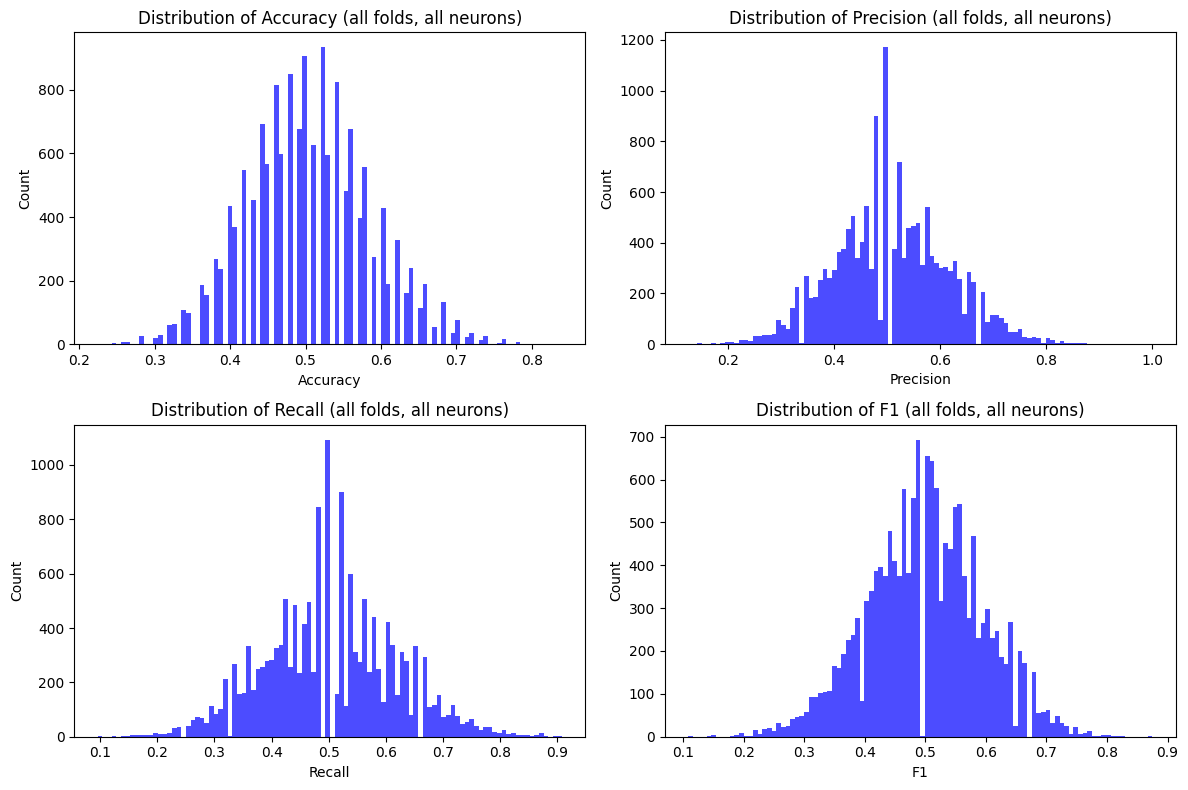

In [30]:
#SER - Ri-1 (projected in reactivation space, prediction reactivations with SER)
LR_model(X_all, y_all)

[[-1  1  1 ... -1 -1  1]
 [ 1  1 -1 ...  1 -1 -1]
 [ 1 -1 -1 ... -1  1 -1]
 ...
 [ 1 -1 -1 ... -1  1  1]
 [-1 -1 -1 ...  1  1 -1]
 [ 1  1  1 ...  1 -1  1]]
X_all shape: (248, 3124), y_all shape: (248, 3124)

=== Cross-Validation Summary ===
Accuracy:  0.564 ± 0.081
Precision: 0.570
Recall:    0.559
F1-score:  0.557


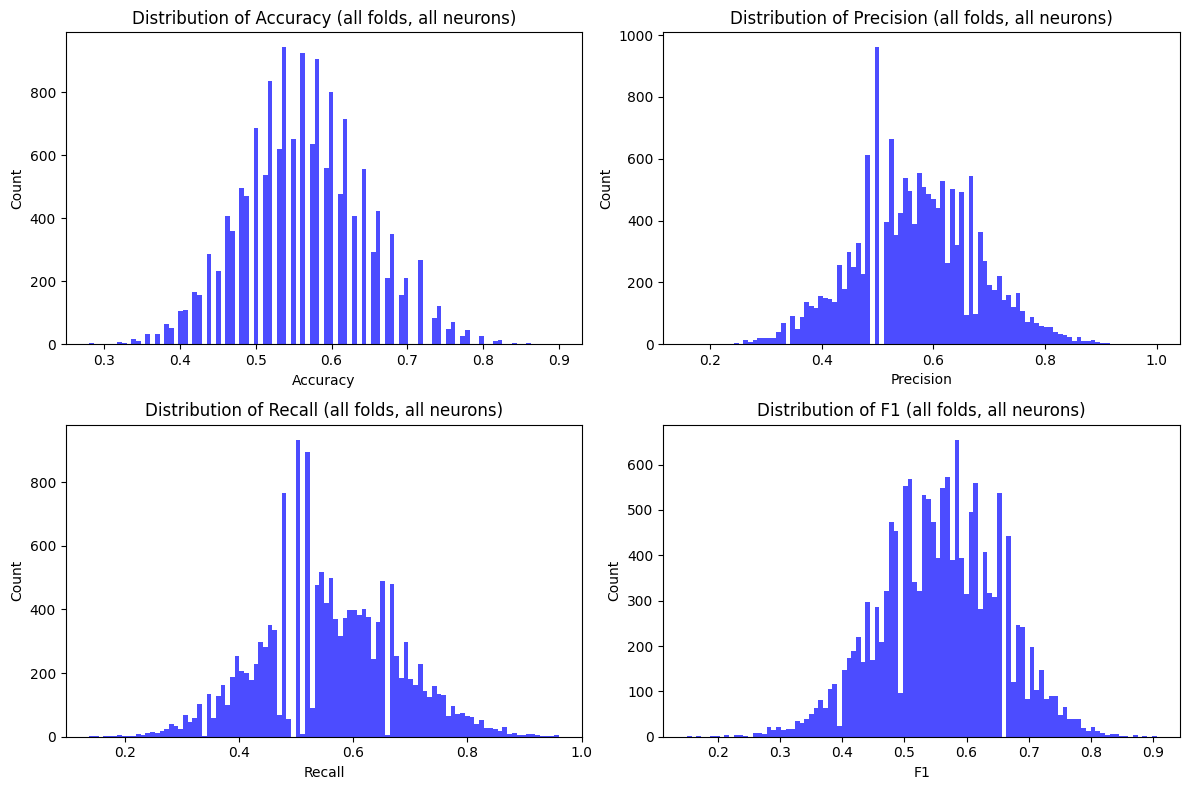

In [31]:
X_all = np.concatenate([mean_activity_r_1[:-1, ], mean_activity_r_2[:-1, ]])
y_1 = np.diff(mean_activity_r_1, axis=0)
y_2 = np.diff(mean_activity_r_2, axis=0)
y_all = np.concatenate([y_1, y_2])

sign_changes = np.where(y_all > 0, 1, -1)
print(sign_changes)

#raw Ri-1 data (in R space)
LR_model(X_all, sign_changes)

X_all shape: (248, 3124), y_all shape: (248, 3124)



=== Cross-Validation Summary ===
Accuracy:  0.538 ± 0.068
Precision: 0.525
Recall:    0.803
F1-score:  0.615


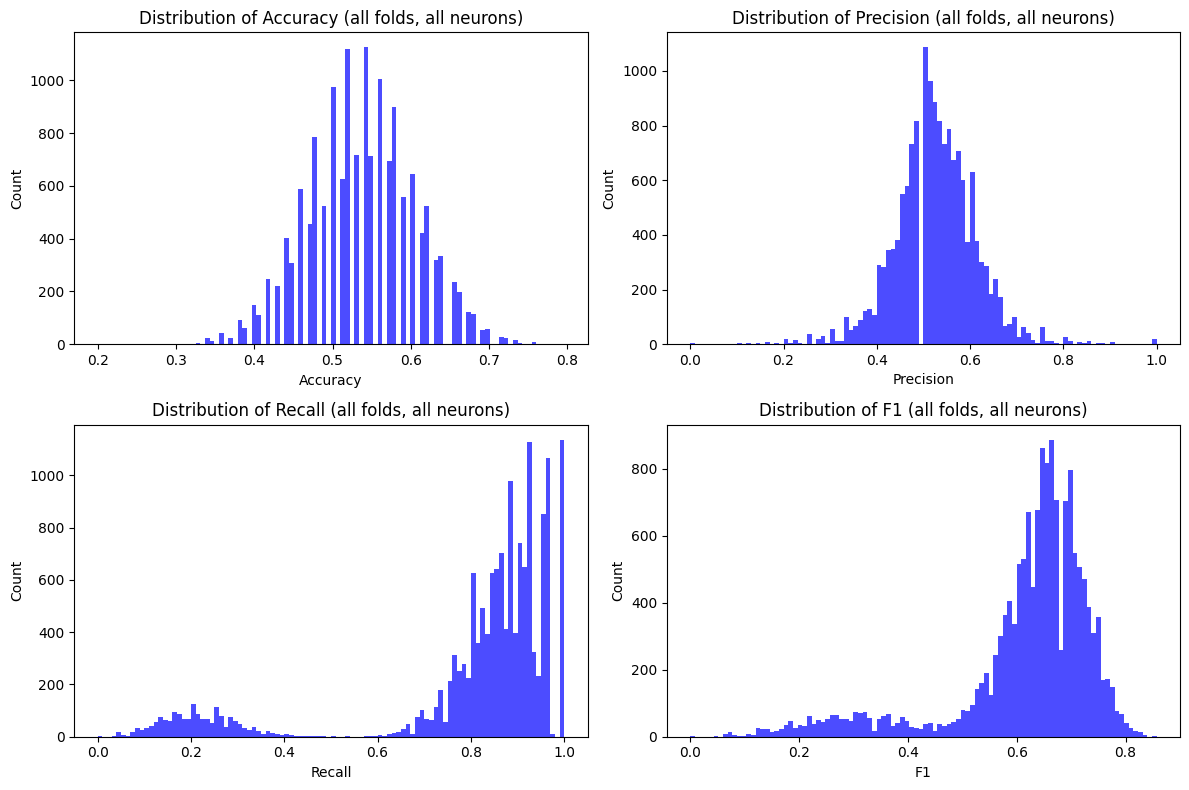

In [9]:
X_cs_1, y_cs_1_clean = clean_and_prepare_data_r(mean_activity_r_1, mean_activity_cs_1, trial_r_1)
X_cs_2, y_cs_2_clean = clean_and_prepare_data_r(mean_activity_r_2, mean_activity_cs_2, trial_r_2)

X_cs_1_diff = np.diff(mean_activity_cs_1[trial_r_1, ], axis=0)
X_cs_2_diff = np.diff(mean_activity_cs_2[trial_r_2, ], axis=0)

X_all = np.concatenate([X_cs_1_diff, X_cs_2_diff]) 
y_all = np.concatenate([y_cs_1_clean, y_cs_2_clean]) 

#SERt - SERt-1 (in reactivation space)
LR_model(X_all, y_all)

#wow ????


X_all shape: (248, 3124), y_all shape: (248, 3124)

=== Cross-Validation Summary ===
Accuracy:  0.410 ± 0.068
Precision: 0.409
Recall:    0.406
F1-score:  0.402


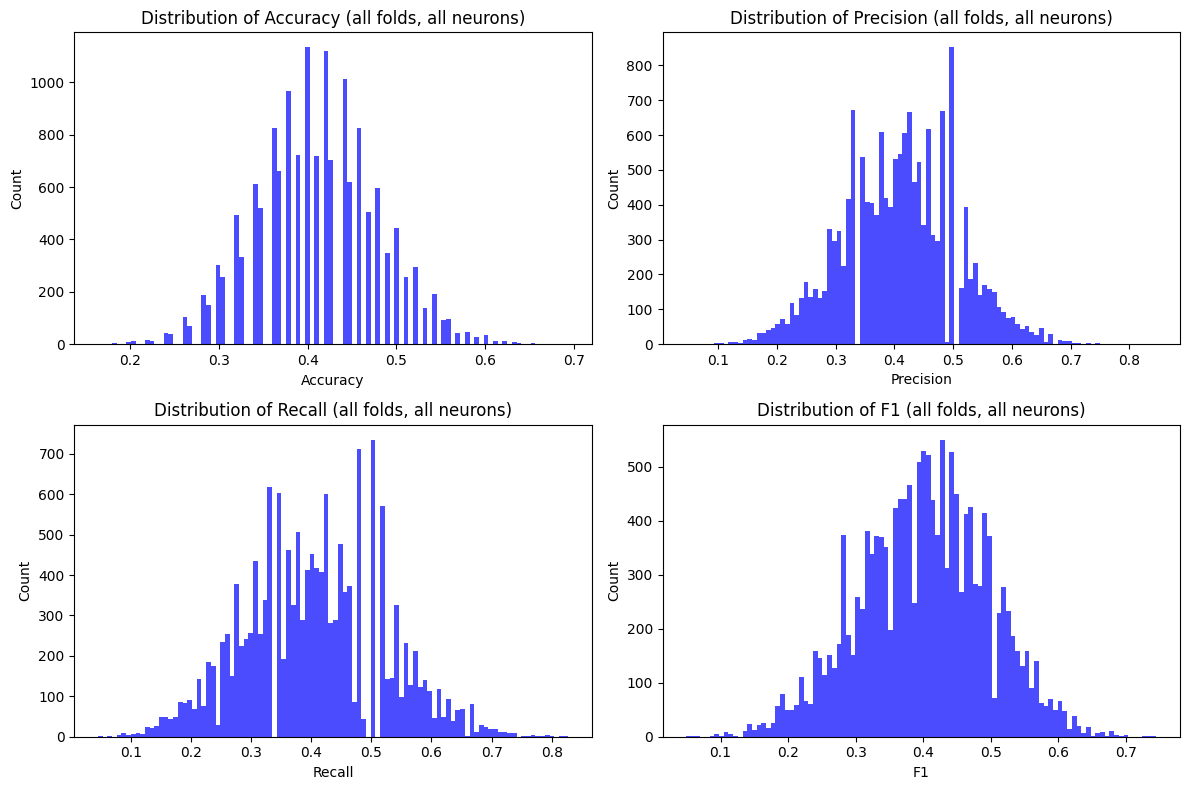

In [38]:
X_cs_1, y_cs_1_clean = clean_and_prepare_data_r(mean_activity_r_1, mean_activity_cs_1, trial_r_1)
X_cs_2, y_cs_2_clean = clean_and_prepare_data_r(mean_activity_r_2, mean_activity_cs_2, trial_r_2)

X_all = np.concatenate([mean_activity_cs_1[trial_r_1[:-1], ], mean_activity_cs_2[trial_r_2[:-1], ]])  # Shape: (total_reactivations, neurons)
y_all = np.concatenate([y_cs_1_clean, y_cs_2_clean]) 

#raw SER data (projected in reactivation space)
LR_model(X_all, y_all)

[[ 1  1 -1 ...  1 -1 -1]
 [ 1 -1 -1 ... -1  1 -1]
 [-1  1  1 ... -1 -1 -1]
 ...
 [ 1 -1 -1 ... -1  1  1]
 [-1 -1 -1 ...  1  1 -1]
 [ 1  1  1 ...  1 -1  1]]
X_all shape: (246, 3124), y_all shape: (246, 3124)

=== Cross-Validation Summary ===
Accuracy:  0.643 ± 0.069
Precision: 0.648
Recall:    0.648
F1-score:  0.641


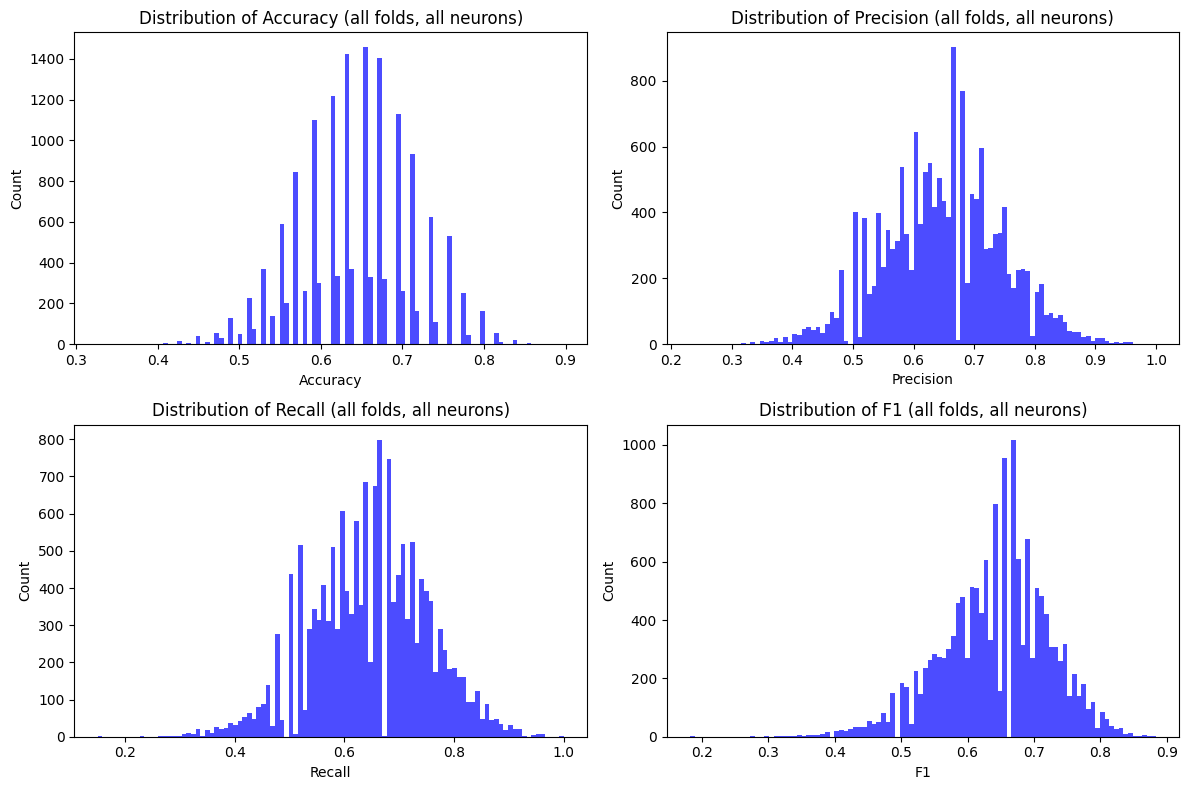

In [39]:
x_1 = np.diff(mean_activity_r_1, axis= 0)
x_2 = np.diff(mean_activity_r_2, axis=0)

X_all = np.concatenate([x_1[:-1, ], x_2[:-1, ]])
y_1 = np.diff(mean_activity_r_1, axis=0)
y_2 = np.diff(mean_activity_r_2, axis=0)
#taget Ri+1
y_all = np.concatenate([y_1[1:, ], y_2[1:, ]])

sign_changes = np.where(y_all > 0, 1, -1)
print(sign_changes)

#Ri - Ri-1
LR_model(X_all, sign_changes)

# Neuron distr

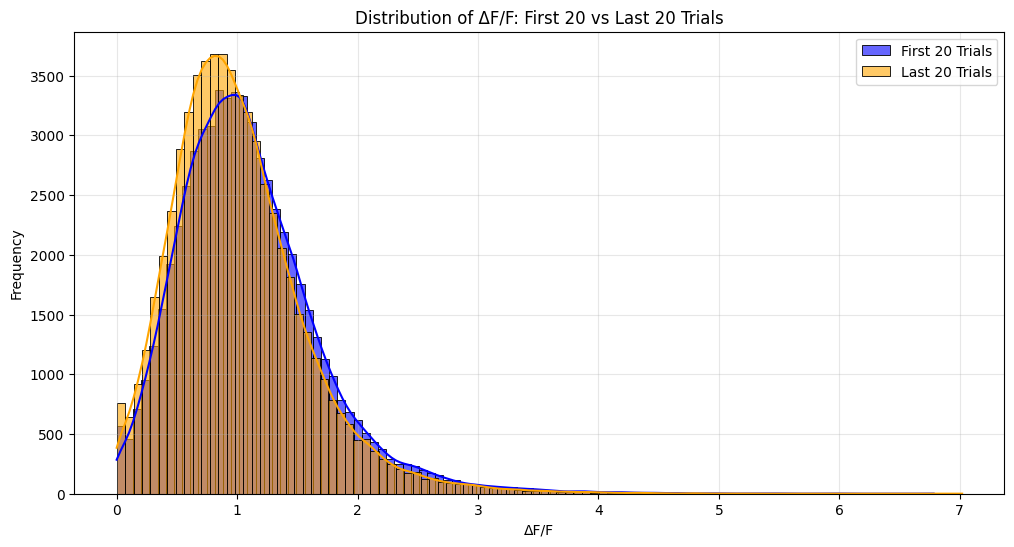

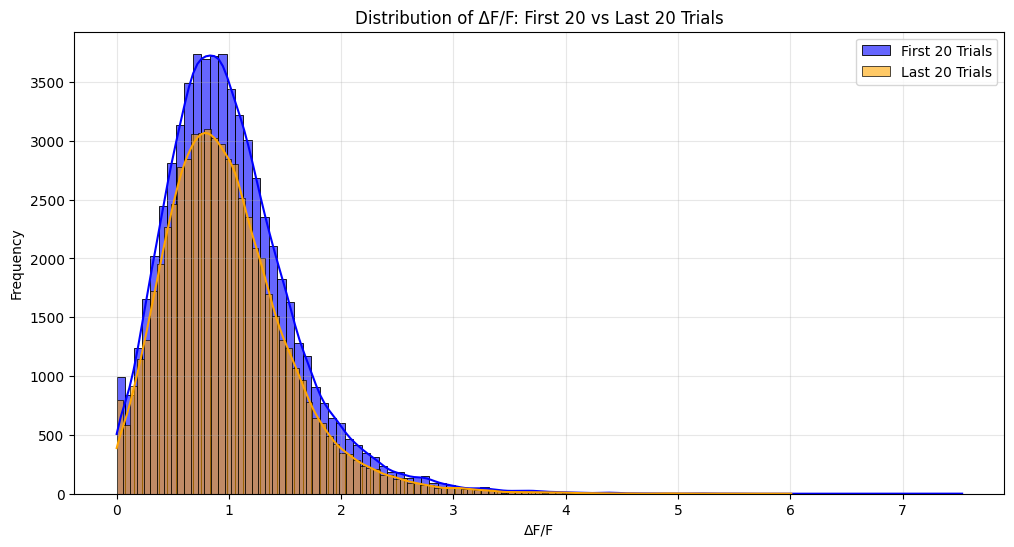

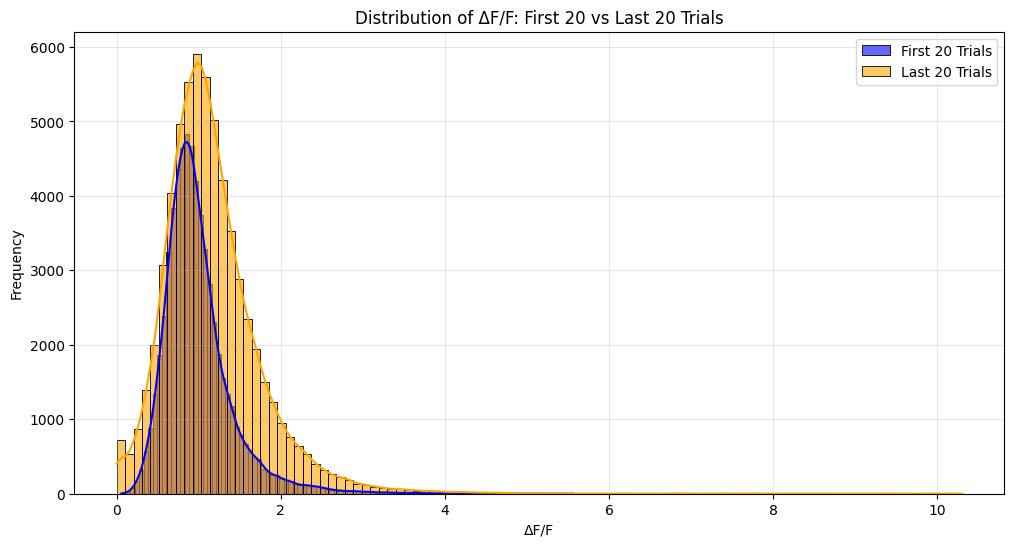

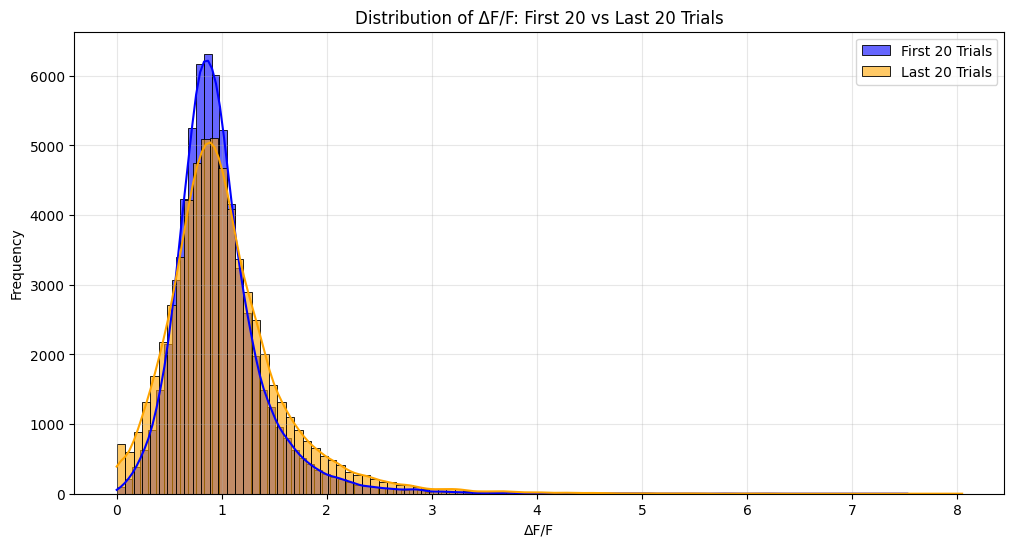

In [ ]:
def plot_delta_f_over_f(mean_activity_cs, num_trials_to_compare=20, alpha_value=0.6):
    """
    Distribution of ΔF/F values for the first and last N trials of mean_activity_cs

    - mean_activity_cs: 2D numpy array (n_trials, n_neurons), trial-level fluorescence activity
    - num_trials_to_compare: int, number of trials to compare (default=20)
    - alpha_value: float, transparency level for the plot (default=0.6)"""

    n_trials, n_neurons = mean_activity_cs.shape

    # Select first and last N trials
    first_trials = mean_activity_cs[:num_trials_to_compare].flatten()
    last_trials = mean_activity_cs[-num_trials_to_compare:].flatten()

    # Plot the distribution using seaborn
    plt.figure(figsize=(12, 6))

    sns.histplot(first_trials, kde=True, color='blue', bins=100, alpha=alpha_value, label=f'First {num_trials_to_compare} Trials')
    sns.histplot(last_trials, kde=True, color='orange', bins=100, alpha=alpha_value, label=f'Last {num_trials_to_compare} Trials')

    plt.title(f'Distribution of ΔF/F: First {num_trials_to_compare} vs Last {num_trials_to_compare} Trials')
    plt.xlabel('ΔF/F')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()



plot_delta_f_over_f(mean_activity_cs_1)
plot_delta_f_over_f(mean_activity_cs_2)
plot_delta_f_over_f(mean_activity_r_1)
plot_delta_f_over_f(mean_activity_r_2)


In [123]:
print(mean_activity_cs_1.shape, mean_activity_cs_2.shape, mean_activity_r_1.shape, mean_activity_r_2.shape)

(68, 3124) (60, 3124) (139, 3124) (111, 3124)


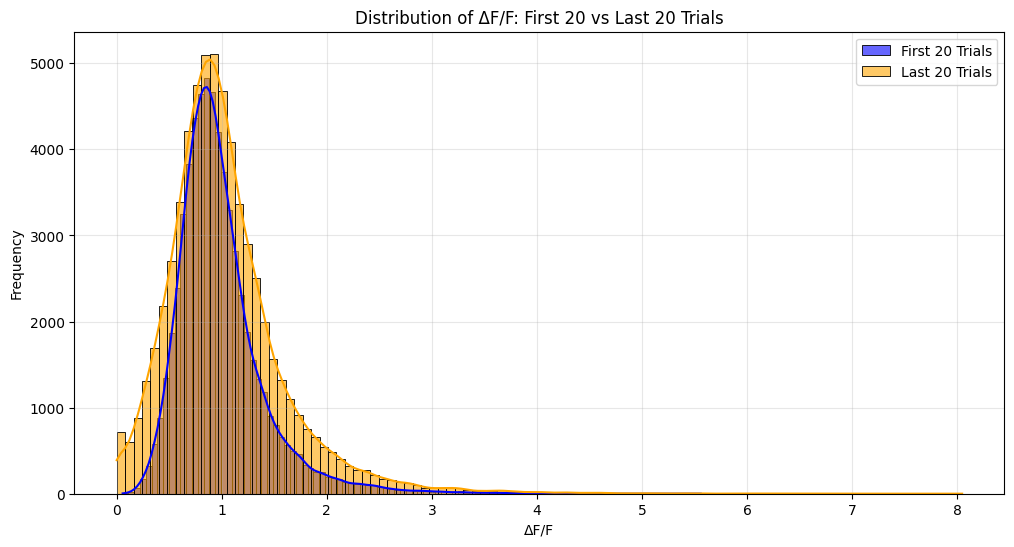

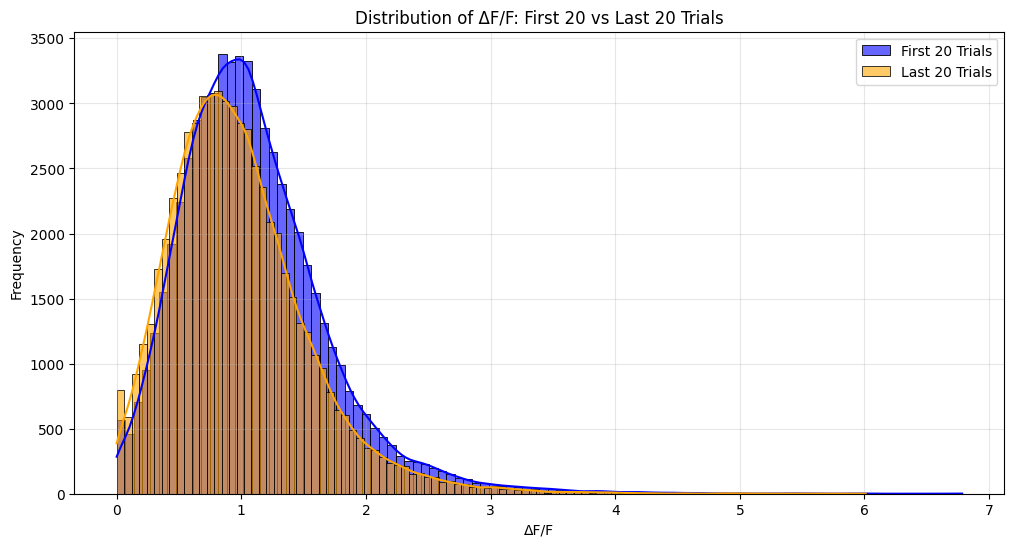

In [19]:
reacts = np.concatenate([mean_activity_r_1, mean_activity_r_2])
SERs = np.concatenate([mean_activity_cs_1, mean_activity_cs_2])

plot_delta_f_over_f(reacts)
plot_delta_f_over_f(SERs)


# Analysis best model features (which reactivations are most predictive for SER drift)

X_all shape: (250, 3124), y_all shape: (250, 3124)



=== Cross-Validation Summary ===
Accuracy:  0.858 ± 0.047
Precision: 0.858
Recall:    0.861
F1-score:  0.856


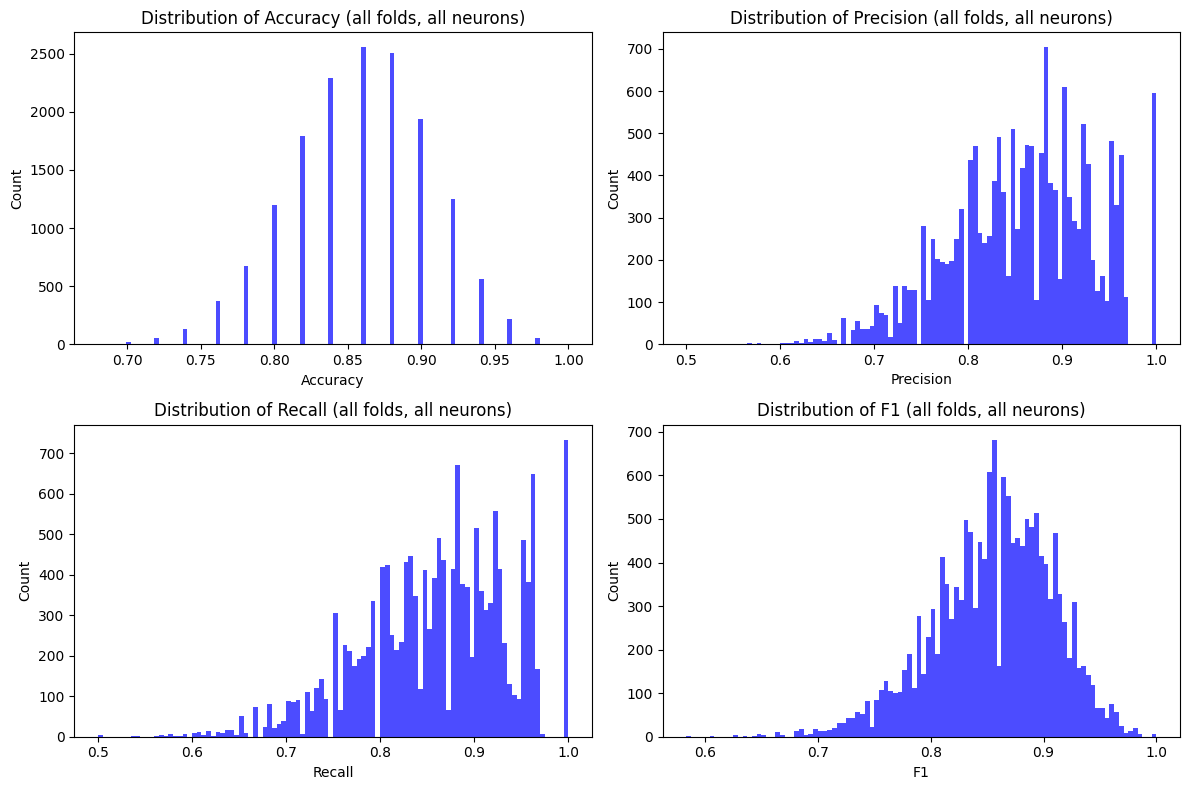

Misclassified event indices: [  0   2   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  93  94
  95  96  97  98 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 134 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 201 202 203 205 206 207 209
 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 247 248 249]


In [22]:
#Ri - SERt-1 (projected in reactivation space)
oof_preds, oof_true = LR_model(X_all, y_all)

# events where at least one neuron is misclassified
event_misclassified = np.any(oof_preds != oof_true, axis=1)

# or events entirely misclassified (if your problem is multi-label):
# event_misclassified = np.all(oof_preds != oof_true, axis=1)

misclassified_indices = np.where(event_misclassified)[0]
print("Misclassified event indices:", misclassified_indices)

i = 0  # pick a specific event
print("True labels for event i:", oof_true[i])
print("Predicted labels for event i:", oof_preds[i])






